In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
from matplotlib_venn import venn2
import seaborn as sb

In [2]:
dir_fig = 'plots_svs/'

In [3]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
display(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

def get_cov(sample, plat):
    try:
        ret = df_cov[(df_cov.SAMPLE == sample) & (df_cov.COHORT == plat)]['MEAN_COVERAGE'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

plat_dict = {sample: get_plat(sample) for sample in df_cov.SAMPLE.tolist()}

,SAMPLE,COHORT,MEAN_COVERAGE
0,HG004,ONT,81.44
1,REACH000626,ONT,10.51
2,REACH000546,ONT,10.87
3,REACH000683,ONT,9.97
4,REACH000563,ONT,8.68
...,...,...,...
283,REACH000284,PB,3.43
284,REACH000672,PB,5.02
285,REACH000292,PB,9.00
286,REACH000066,PB,1.61


In [4]:
# read the big table
file_name = 'test.tsv'
df = pd.read_table(file_name, sep='\t', header=0)

/scratch/smmortazavi/job_35581079/ipykernel_2887198/1689111987.py:3: DtypeWarning: Columns (25,70,72,73,77,78,79,80,81,82,83,84,88,99,100,101,102,103,104,105,106,110,111,112,113,114,115,116,117,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(file_name, sep='\t', header=0)


In [6]:
#def get_df_flt(df, flt_name, svtypes, ext_col=None, flt_sd_art=True, freq_thr=None):
#    if not ext_col:
#        df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes))].copy()
#    else:
#        df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes)) & (df[ext_col]==1)].copy()
#    if flt_sd_art:
#        df_flt = df_flt.loc[~((df_flt.SD_ART==1) & (df_flt.PLATFORM=='LR'))].copy()
#    if freq_thr != None:
#        df_flt = df_flt.loc[df_flt[f'freq_{flt_name}']<=freq_thr].copy()
#    return df_flt

#def get_df_flt(df, flt_name, svtypes, ext_col=None, flt_sd_art=True, freq_col=None, freq_thr=None):
#    if not ext_col:
#        df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes))]
#    else:
#        df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes)) & (df[ext_col]==1)]
#    if flt_sd_art:
#        df_flt = df_flt.loc[~((df_flt.SD_ART==1) & (df_flt.PLATFORM=='LR'))]
#    if freq_thr != None:
#        df_flt = df_flt.loc[df_flt[f'freq_{freq_col}']<=freq_thr]
#    return df_flt

def get_df_flt(df, flt_name, svtypes, ext_col=None, flt_sd_art=True, freq_col=None, freq_thr=None):
    df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0) | (df['NUM_IL_GT_SAMPLES'] > 0) | (df['NUM_SV2_GT_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes))]
    #| (df['NUM_SV2_GT_SAMPLES'] > 0)
    if flt_sd_art:
        df_flt = df_flt.loc[~((df_flt.SD_ART==1) & (df_flt.PLATFORM=='LR'))]
    if freq_thr != None:
        df_flt = df_flt.loc[df_flt[f'freq_{freq_col}']<=freq_thr]
    return df_flt

plots_svs/filter_calls_freq1.png


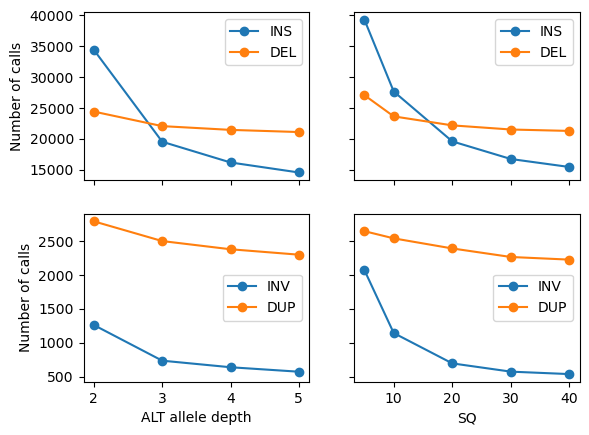

plots_svs/filter_calls_total_freq1.png


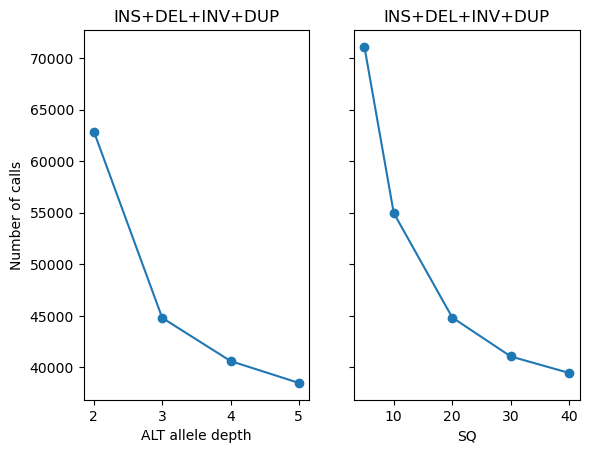

In [7]:
##############################
### plot filtering AD, SQ
##############################
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
freq_thr = 1
#freq_thr = 0.05
freq_col = 'AD2_SAMPLES'

ads = [2, 3, 4, 5]
qs = [5, 10, 20, 30, 40]
sv_counts_ad = []
sv_counts_q = []
for ad in ads:
    #print(f'++++++++++++ AD{ad} filter ++++++++++')
    #this_df = df.loc[(df[f'NUM_AD{ad}_SAMPLES'] > 0) | (df['NUM_IL_SAMPLES'] > 0)]
    flt_name = f'AD{ad}_SAMPLES'
    this_df = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=False, freq_col=freq_col, freq_thr=freq_thr)
    this_counts = this_df.SVTYPE.value_counts()
    this_counts['INS'] = this_counts['INS'] + this_counts['.']
    sv_counts_ad.append(this_counts)
    #n_pass = this_df.shape[0]
    #print(f'AD{ad} filter, N pass: {n_pass}')
    #print(sv_counts_ad[-1])
    
    #this_df_cov = df.loc[(df[f'NUM_AD{ad}_SAMPLES'] > 0) & (df['NUM_ZERO_COV_SAMPLES'] < N_ZERO_COV_THR)]
    #n_pass_cov = this_df_cov.shape[0]
    #print(this_df_cov.SVTYPE.value_counts())
    #print(f'AD{ad} filter with N_ZERO_COV < {N_ZERO_COV_THR}, N pass: {n_pass_cov}')
    #print()
    
for q in qs:
    #print(f'++++++++++++ SQ{q} filter ++++++++++')
    #this_df = df.loc[(df[f'NUM_SQ{q}_SAMPLES'] > 0) | (df['NUM_IL_SAMPLES'] > 0)]
    flt_name = f'SQ{q}_SAMPLES'
    this_df = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=False, freq_col=freq_col, freq_thr=freq_thr)
    this_counts = this_df.SVTYPE.value_counts()
    this_counts['INS'] = this_counts['INS'] + this_counts['.']
    sv_counts_q.append(this_counts)
    #n_pass = this_df.shape[0]
    #print(f'SQ{q} filter, N pass: {n_pass}')
    #print(sv_counts_q[-1])
    
    #this_df_cov = df.loc[(df[f'NUM_SQ{q}_SAMPLES'] > 0) & (df['NUM_ZERO_COV_SAMPLES'] < N_ZERO_COV_THR)]
    #n_pass_cov = this_df_cov.shape[0]
    #print(f'SQ{q} filter with N_ZERO_COV < {N_ZERO_COV_THR}, N pass: {n_pass_cov}')
    #print(this_df_cov.SVTYPE.value_counts())
    #print()

###########################
fig, axs = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='col')
svtypes_1 = ['INS', 'DEL']
svtypes_2 = ['INV', 'DUP']
for svtype in svtypes_1:
    axs[0, 0].plot(ads, [x[svtype] for x in sv_counts_ad], '-o', label=svtype)
for svtype in svtypes_1:
    axs[0, 1].plot(qs, [x[svtype] for x in sv_counts_q], '-o', label=svtype)
for svtype in svtypes_2:
    axs[1, 0].plot(ads, [x[svtype] for x in sv_counts_ad], '-o', label=svtype)
for svtype in svtypes_2:
    axs[1, 1].plot(qs, [x[svtype] for x in sv_counts_q], '-o', label=svtype)

axs[1, 0].set_xlabel('ALT allele depth')
axs[1, 1].set_xlabel('SQ')
axs[0, 0].set_ylabel('Number of calls')
axs[1, 0].set_ylabel('Number of calls')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

fig_name = dir_fig+f'filter_calls_freq{freq_thr}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

svtypes = ['INS', 'DEL', 'INV', 'DUP']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
ax1.plot(ads, [x[svtypes].sum() for x in sv_counts_ad], '-o')
ax2.plot(qs, [x[svtypes].sum() for x in sv_counts_q], '-o')
ax1.set_xlabel('ALT allele depth')
ax2.set_xlabel('SQ')
ax1.set_ylabel('Number of calls')
ax1.set_title('+'.join(svtypes))
ax2.set_title('+'.join(svtypes))
fig_name = dir_fig+f'filter_calls_total_freq{freq_thr}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

total: (344735, 434)
filtered: (44636, 434)
len(samples_cases_list): 472672
len(samples_controls_list): 947018
plots_svs/sample_case_SQ20_SAMPLES_counts_hist_freq1


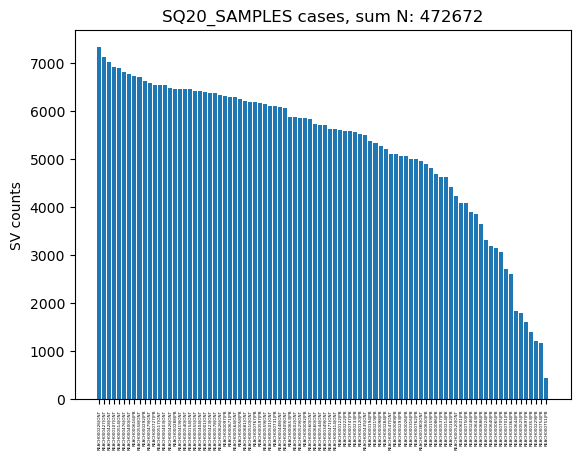

plots_svs/sample_control_SQ20_SAMPLES_counts_hist_freq1


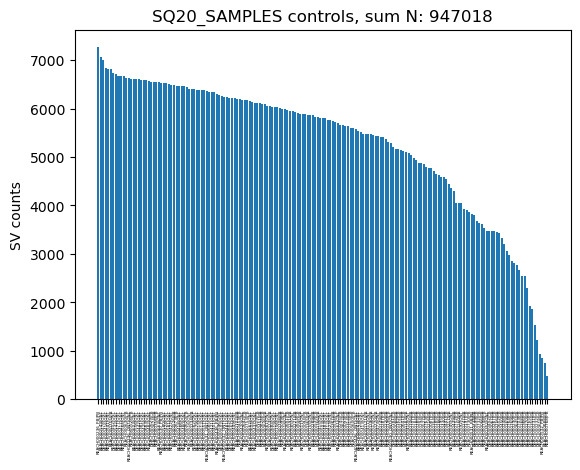

plots_svs/coverage_vs_svCount_SQ20_SAMPLES_freq1.png


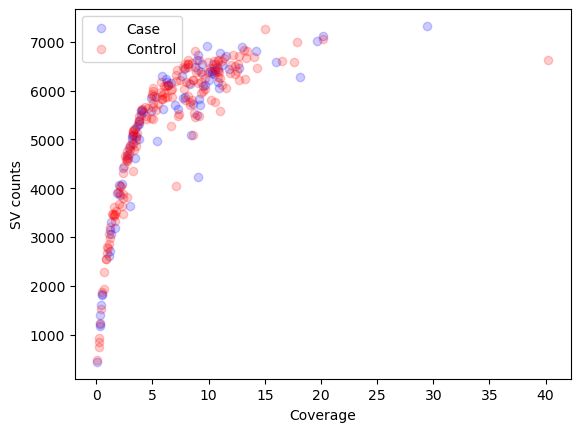

plots_svs/coverage_vs_svCount_SQ20_SAMPLES_freq1_plat.png


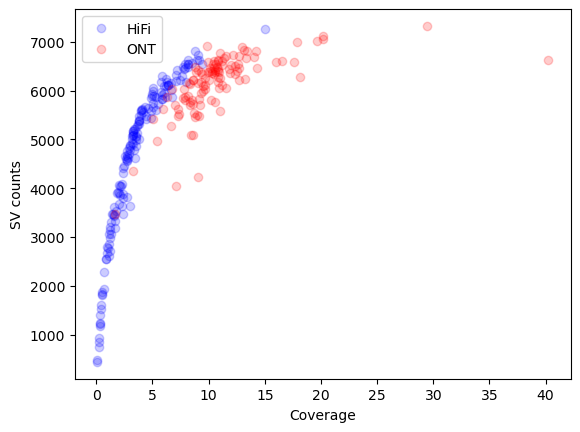

In [9]:
##########################################
### number of calls for each sample
##########################################
#flt_name = 'AD3_SAMPLES'
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=1
#freq_thr=0.05
freq_col = 'AD2_SAMPLES'

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

samples_cases_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(df_flt[flt_name].str.split(',').tolist(), 
                                          df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                      for y, c in zip(xs, cs) if c=='Yes']

samples_controls_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(df_flt[flt_name].str.split(',').tolist(), 
                                          df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                      for y, c in zip(xs, cs) if c=='No']

print('len(samples_cases_list):', len(samples_cases_list))
print('len(samples_controls_list):', len(samples_controls_list))

df_cases = pd.DataFrame({'samples': samples_cases_list})
case_count_nums = df_cases.value_counts().tolist()
case_count_samples = df_cases.value_counts().index.get_level_values(0).tolist()
#print('count cases:')
#print(case_count_nums)
#print(case_count_samples)
df_case_samples = pd.DataFrame({'samples': [x.split('|')[0] for x in case_count_samples], 
                             'plat': [x.split('|')[1] for x in case_count_samples]})
df_case_samples['coverage'] = df_case_samples.apply(lambda row: df_cov.loc[(df_cov.SAMPLE==row['samples']) & 
                                              (df_cov.COHORT==row['plat'])]['MEAN_COVERAGE'].tolist()[0], axis=1)
df_case_samples['counts'] = case_count_nums
#print('df_case_samples:')
#print(df_case_samples)


df_controls = pd.DataFrame({'samples': samples_controls_list})
control_count_nums = df_controls.value_counts().tolist()
control_count_samples = df_controls.value_counts().index.get_level_values(0).tolist()
#print('count controls:')
#print(control_count_nums)
#print(control_count_samples)
df_control_samples = pd.DataFrame({'samples': [x.split('|')[0] for x in control_count_samples], 
                             'plat': [x.split('|')[1] for x in control_count_samples]})
df_control_samples['coverage'] = df_control_samples.apply(lambda row: df_cov.loc[(df_cov.SAMPLE==row['samples']) & 
                                              (df_cov.COHORT==row['plat'])]['MEAN_COVERAGE'].tolist()[0], axis=1)
df_control_samples['counts'] = control_count_nums
#print('df_control_samples:')
#print(df_control_samples)

df_all_samples = pd.concat([df_case_samples, df_control_samples], axis=0, ignore_index=False)
#print('df_all_samples:')
#print(df_all_samples)

fig, ax = plt.subplots()
ax.bar(case_count_samples, case_count_nums)
ax.set_xticks(case_count_samples, case_count_samples, rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(f'{flt_name} cases, sum N: {df_cases.shape[0]}')
fig_name = dir_fig+f'sample_case_{flt_name}_counts_hist_freq{freq_thr}'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
ax.bar(control_count_samples, control_count_nums)
ax.set_xticks(control_count_samples, control_count_samples, rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(f'{flt_name} controls, sum N: {df_controls.shape[0]}')
fig_name = dir_fig+f'sample_control_{flt_name}_counts_hist_freq{freq_thr}'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

### coverage vs SV counts
plt.figure()
plt.plot(df_case_samples['coverage'], case_count_nums, 'ob', alpha=.2, label='Case')
plt.plot(df_control_samples['coverage'], control_count_nums, 'or', alpha=.2, label='Control')
plt.legend()
plt.xlabel('Coverage')
plt.ylabel('SV counts')
fig_name = dir_fig+f'coverage_vs_svCount_{flt_name}_freq{freq_thr}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

### coverage vs SV counts hue platform
plt.figure()
this_df = df_all_samples.loc[df_all_samples.plat=='PB']
plt.plot(this_df['coverage'], this_df['counts'], 'ob', alpha=.2, label='HiFi')
this_df = df_all_samples.loc[df_all_samples.plat=='ONT']
plt.plot(this_df['coverage'], this_df['counts'], 'or', alpha=.2, label='ONT')
plt.legend()
plt.xlabel('Coverage')
plt.ylabel('SV counts')
fig_name = dir_fig+f'coverage_vs_svCount_{flt_name}_freq{freq_thr}_plat.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

total: (344736, 451)
filtered: (25670, 451)
len(samples_cases_list): 13269
len(samples_controls_list): 27905
plots_svs/sample_case_AD3_SAMPLES_counts_hist_freq0.05


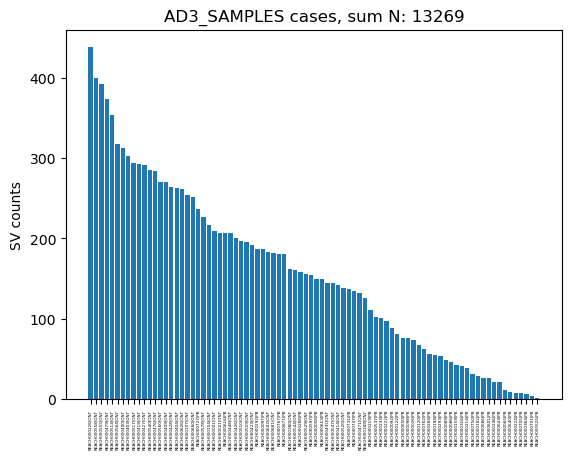

plots_svs/sample_control_AD3_SAMPLES_counts_hist_freq0.05


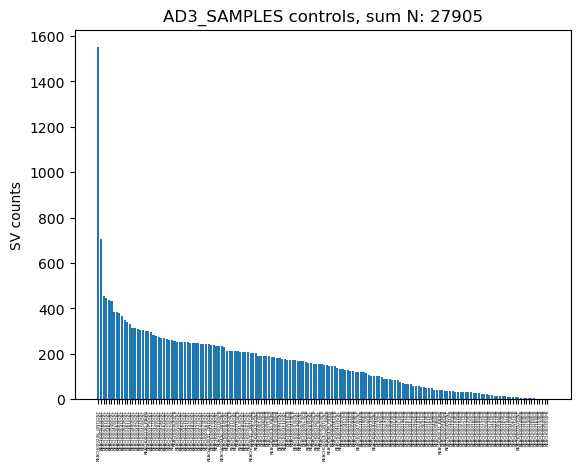

plots_svs/coverage_vs_svCount_AD3_SAMPLES_freq0.05.png


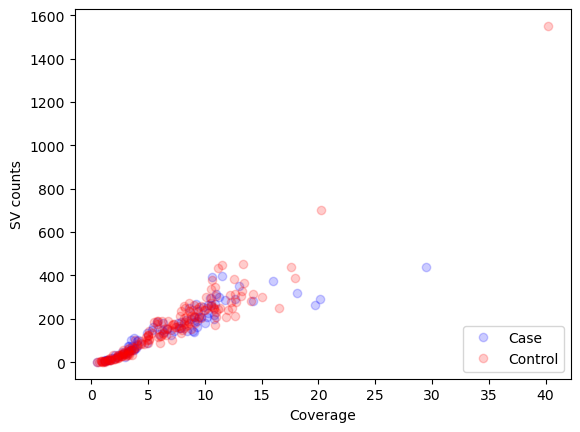

In [18]:
##########################################
### number of calls for each sample
##########################################
flt_name = 'AD3_SAMPLES'
#flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

#freq_thr=1
freq_thr=0.05
freq_col = 'AD2_SAMPLES'

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

samples_cases_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(df_flt[flt_name].str.split(',').tolist(), 
                                          df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                      for y, c in zip(xs, cs) if c=='Yes']

samples_controls_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(df_flt[flt_name].str.split(',').tolist(), 
                                          df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                      for y, c in zip(xs, cs) if c=='No']

print('len(samples_cases_list):', len(samples_cases_list))
print('len(samples_controls_list):', len(samples_controls_list))

df_cases = pd.DataFrame({'samples': samples_cases_list})
case_count_nums = df_cases.value_counts().tolist()
case_count_samples = df_cases.value_counts().index.get_level_values(0).tolist()
#print('count cases:')
#print(case_count_nums)
#print(case_count_samples)
df_case_samples = pd.DataFrame({'samples': [x.split('|')[0] for x in case_count_samples], 
                             'plat': [x.split('|')[1] for x in case_count_samples]})
df_case_samples['coverage'] = df_case_samples.apply(lambda row: df_cov.loc[(df_cov.SAMPLE==row['samples']) & 
                                              (df_cov.COHORT==row['plat'])]['MEAN_COVERAGE'].tolist()[0], axis=1)
#print(df_case_samples)


df_controls = pd.DataFrame({'samples': samples_controls_list})
control_count_nums = df_controls.value_counts().tolist()
control_count_samples = df_controls.value_counts().index.get_level_values(0).tolist()
#print('count controls:')
#print(control_count_nums)
#print(control_count_samples)
df_control_samples = pd.DataFrame({'samples': [x.split('|')[0] for x in control_count_samples], 
                             'plat': [x.split('|')[1] for x in control_count_samples]})
df_control_samples['coverage'] = df_control_samples.apply(lambda row: df_cov.loc[(df_cov.SAMPLE==row['samples']) & 
                                              (df_cov.COHORT==row['plat'])]['MEAN_COVERAGE'].tolist()[0], axis=1)
#print(df_control_samples)

fig, ax = plt.subplots()
ax.bar(case_count_samples, case_count_nums)
ax.set_xticks(case_count_samples, case_count_samples, rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(f'{flt_name} cases, sum N: {df_cases.shape[0]}')
fig_name = dir_fig+f'sample_case_{flt_name}_counts_hist_freq{freq_thr}'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
ax.bar(control_count_samples, control_count_nums)
ax.set_xticks(control_count_samples, control_count_samples, rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(f'{flt_name} controls, sum N: {df_controls.shape[0]}')
fig_name = dir_fig+f'sample_control_{flt_name}_counts_hist_freq{freq_thr}'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

### coverage vs SV counts
plt.figure()
plt.plot(df_case_samples['coverage'], case_count_nums, 'ob', alpha=.2, label='Case')
plt.plot(df_control_samples['coverage'], control_count_nums, 'or', alpha=.2, label='Control')
plt.legend(loc='lower right')
plt.xlabel('Coverage')
plt.ylabel('SV counts')
fig_name = dir_fig+f'coverage_vs_svCount_{flt_name}_freq{freq_thr}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

total: (344736, 323)
filtered: (27669, 323)
plots_svs/hist_zero_cov_samples.png


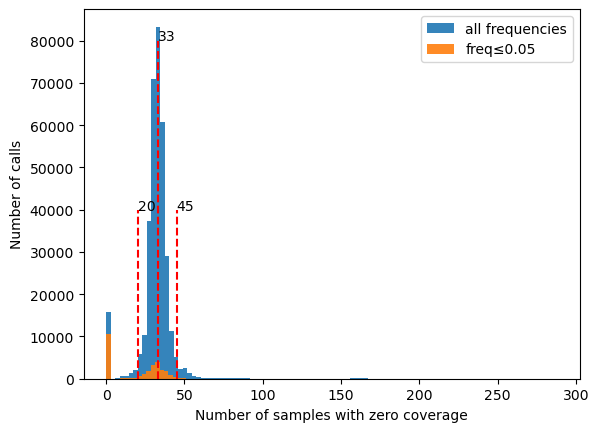

In [7]:
##########################################
### zero coverage sample distribution
##########################################
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

plt.figure()
plt.hist(df.NUM_ZERO_COV_SAMPLES, bins=100, label='all frequencies', alpha=.9)
plt.hist(df_flt.NUM_ZERO_COV_SAMPLES, bins=100, label='freq≤0.05', alpha=.9)

x_val = 45
y_val = 40000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')	

x_val = 20
y_val = 40000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')	

x_val = 33
y_val = 80000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')

plt.xlabel('Number of samples with zero coverage')
plt.ylabel('Number of calls')
plt.legend()
fig_name = dir_fig+'hist_zero_cov_samples.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [10]:
def venn_(set1only, set2only, set1and2, labels_list, fig_name, title):
    plt.figure()
    venn2(subsets=(set1only, set2only, set1and2),
          set_labels=(labels_list[0], labels_list[1]), set_colors=('skyblue', 'lightgreen'))
    plt.title(title)
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.savefig(fig_name[:-4]+'.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

In [11]:
def hist(df, fig_name='out.png', log_scale=(True, True), bins='auto', palette=sb.color_palette(), sv_set={'DEL', 'DUP', 'INS', 'INV'},
        title='', hue=None):
    plt.figure()
    df_plot = df.loc[df.SVTYPE.isin(sv_set)]
    df_plot = df_plot.loc[df_plot.SVLEN <= 1e6]
    sb.histplot(data=df_plot, x='SVLEN', hue=hue, element="poly", log_scale=log_scale, fill=False, 
                bins=bins, palette=palette, linewidth=3)
    plt.xlabel('SV length')
    plt.title(title)
    plt.xlim(right=1e6)
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.savefig(fig_name[:-4]+'.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

total: (344735, 434)
filtered: (44636, 434)
df_flt_len: (41866, 434)


/scratch/smmortazavi/job_35581079/ipykernel_2887198/2374214415.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.histplot(data=df_plot, x='SVLEN', hue=hue, element="poly", log_scale=log_scale, fill=False,


plots_svs/hist_svlen_allSVs_SQ20_SAMPLES_freq1_noPlat.png


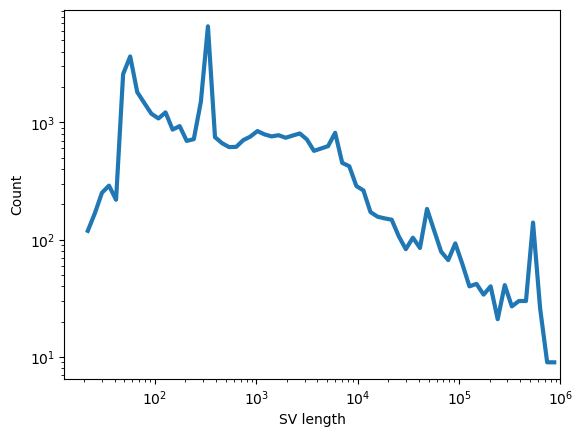

IL_ins: 1721
IL_del: 4639
IL_dup: 618
IL_inv: 100
IL_bnd: 0
LR_ins: 12382
LR_del: 3161
LR_dup: 447
LR_inv: 498
LR_bnd: 0
LR_IL_ins: 4427
LR_IL_del: 14227
LR_IL_dup: 1300
LR_IL_inv: 67
LR_IL_bnd: 0
plots_svs/IL_vs_LR_venn_allSVs_SQ20_SAMPLES_freq1.png


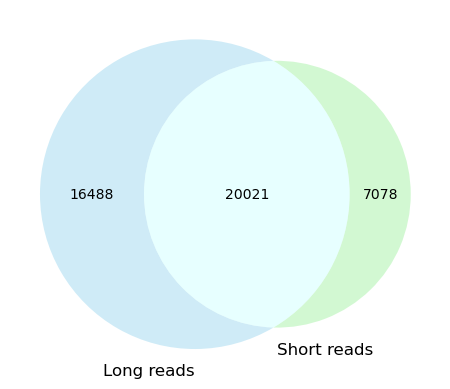

plots_svs/IL_vs_LR_venn_ins_SQ20_SAMPLES_freq1.png


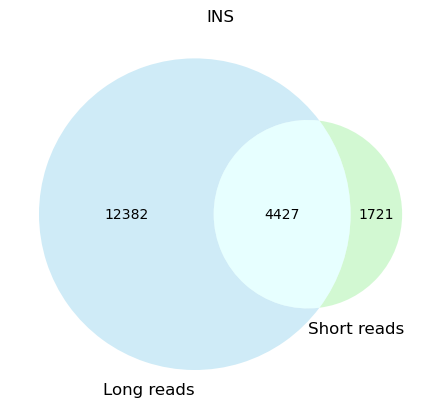

plots_svs/IL_vs_LR_venn_del_SQ20_SAMPLES_freq1.png


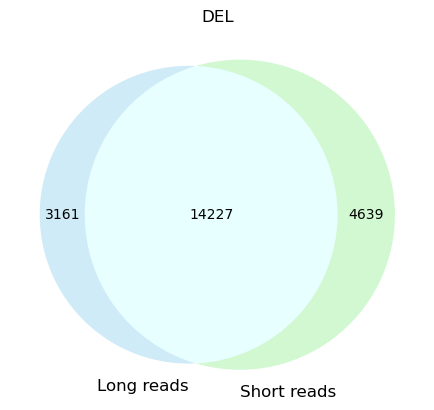

plots_svs/IL_vs_LR_venn_dup_SQ20_SAMPLES_freq1.png


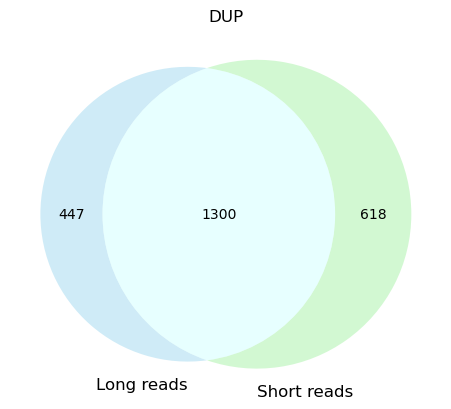

plots_svs/IL_vs_LR_venn_inv_SQ20_SAMPLES_freq1.png


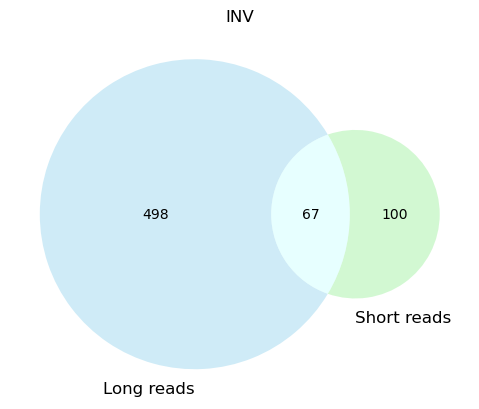

In [12]:
##########################################
### platform discovery rate
##########################################
#flt_name = 'AD3_SAMPLES'
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=1
#freq_thr=0.05
freq_col = 'AD2_SAMPLES'

#title_add = f'{flt_name}, freq≤{freq_thr}'
title_add = f''

############# All variants ##############
# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

df_flt_len = df_flt.loc[df_flt.SVTYPE!='.'].copy()
df_flt_len['SVLEN'] = df_flt_len['SVLEN'].astype(int).abs()
print(f'df_flt_len: {df_flt_len.shape}')
#fig_name = dir_fig+f'hist_svlen_all_svs_{flt_name}_freq{freq_thr}.png'
fig_name = dir_fig+f'hist_svlen_allSVs_{flt_name}_freq{freq_thr}_noPlat.png'
palette = {'LR': 'skyblue', 'IL':'lightgreen', 'LR_IL':'paleturquoise'}
#hist(df_flt_len, fig_name, palette=palette, title=title_add, hue='PLATFORM_CV')
hist(df_flt_len, fig_name, palette=palette, title=title_add)

IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='.')].shape[0]
IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DEL')].shape[0]
IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DUP')].shape[0]
IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='INV')].shape[0]
IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='BND')].shape[0]
IL_total = IL_ins + IL_del + IL_dup + IL_inv
print(f'IL_ins: {IL_ins}')
print(f'IL_del: {IL_del}')
print(f'IL_dup: {IL_dup}')
print(f'IL_inv: {IL_inv}')
print(f'IL_bnd: {IL_bnd}')

LR_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INS')].shape[0]
LR_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DEL')].shape[0]
LR_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DUP')].shape[0]
LR_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INV')].shape[0]
LR_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='BND')].shape[0]
LR_total = LR_ins + LR_del + LR_dup + LR_inv
print(f'LR_ins: {LR_ins}')
print(f'LR_del: {LR_del}')
print(f'LR_dup: {LR_dup}')
print(f'LR_inv: {LR_inv}')
print(f'LR_bnd: {LR_bnd}')

LR_IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INS')].shape[0]
LR_IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DEL')].shape[0]
LR_IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DUP')].shape[0]
LR_IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INV')].shape[0]
LR_IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='BND')].shape[0]
LR_IL_total = LR_IL_ins + LR_IL_del + LR_IL_dup + LR_IL_inv
print(f'LR_IL_ins: {LR_IL_ins}')
print(f'LR_IL_del: {LR_IL_del}')
print(f'LR_IL_dup: {LR_IL_dup}')
print(f'LR_IL_inv: {LR_IL_inv}')
print(f'LR_IL_bnd: {LR_IL_bnd}')

venn_(LR_total, IL_total, LR_IL_total, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_allSVs_{flt_name}_freq{freq_thr}.png', title=''+title_add)
venn_(LR_ins, IL_ins, LR_IL_ins, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_ins_{flt_name}_freq{freq_thr}.png', title='INS'+title_add)
venn_(LR_del, IL_del, LR_IL_del, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_del_{flt_name}_freq{freq_thr}.png', title='DEL'+title_add)
venn_(LR_dup, IL_dup, LR_IL_dup, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_dup_{flt_name}_freq{freq_thr}.png', title='DUP'+title_add)
venn_(LR_inv, IL_inv, LR_IL_inv, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_inv_{flt_name}_freq{freq_thr}.png', title='INV'+title_add)


total: (344735, 434)
filtered: (44636, 434)
df_flt_len: (1232, 434)
plots_svs/hist_svlen_allSVs_coding_SQ20_SAMPLES_freq1_noPlat.png


/scratch/smmortazavi/job_35581079/ipykernel_2887198/2374214415.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.histplot(data=df_plot, x='SVLEN', hue=hue, element="poly", log_scale=log_scale, fill=False,


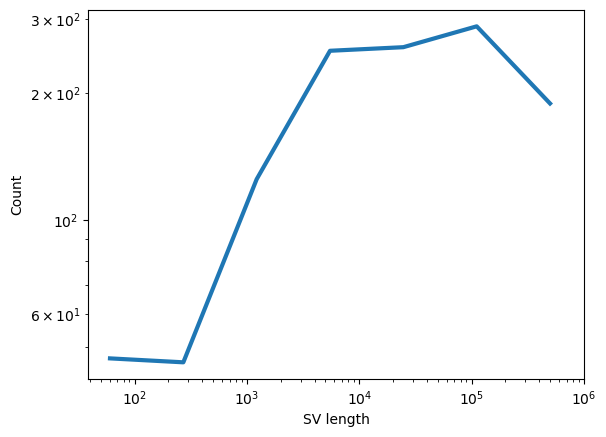

IL_ins: 2
IL_del: 234
IL_dup: 81
IL_inv: 2
IL_bnd: 0
LR_ins: 50
LR_del: 276
LR_dup: 108
LR_inv: 47
LR_bnd: 0
LR_IL_ins: 3
LR_IL_del: 312
LR_IL_dup: 117
LR_IL_inv: 2
LR_IL_bnd: 0
plots_svs/IL_vs_LR_venn_allSVs_coding_SQ20_SAMPLES_freq1.png


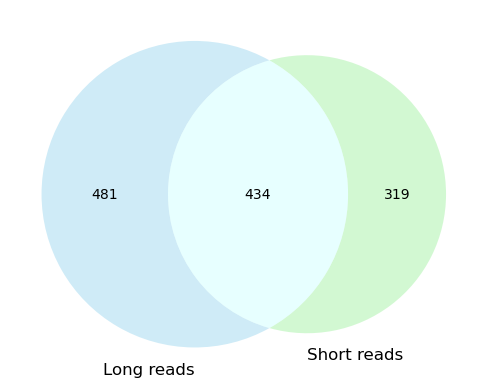

plots_svs/IL_vs_LR_venn_ins_coding_SQ20_SAMPLES_freq1.png


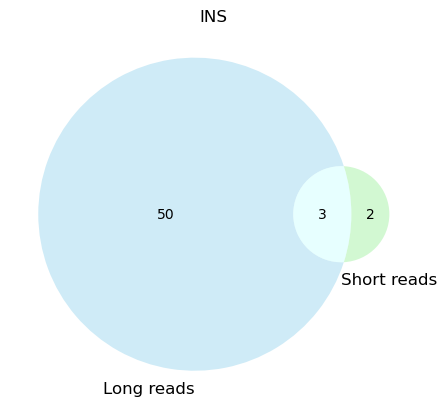

plots_svs/IL_vs_LR_venn_del_coding_SQ20_SAMPLES_freq1.png


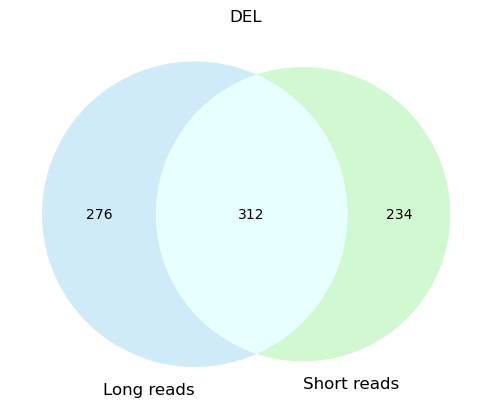

plots_svs/IL_vs_LR_venn_dup_coding_SQ20_SAMPLES_freq1.png


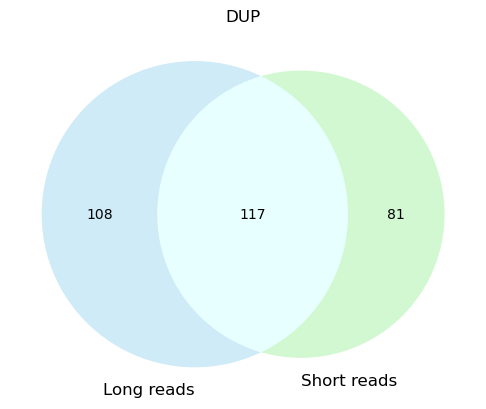

plots_svs/IL_vs_LR_venn_inv_coding_SQ20_SAMPLES_freq1.png


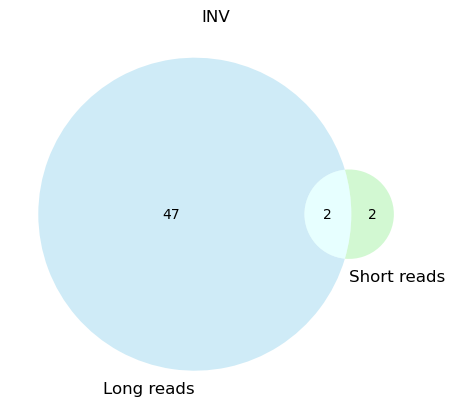

In [13]:
#flt_name = 'AD3_SAMPLES'
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=1
#freq_thr=0.05
freq_col = 'AD2_SAMPLES'

#title_add = f', {flt_name}, freq≤{freq_thr}'
title_add = f''

############# Coding variants ##############
gen_list = ['CDS', 'start_codon', 'stop_codon']
# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

df_flt_len = df_flt.loc[(df_flt.GENCODE.isin(gen_list)) & (df_flt.SVTYPE!='.')].copy()
df_flt_len['SVLEN'] = df_flt_len['SVLEN'].astype(int).abs()
print(f'df_flt_len: {df_flt_len.shape}')
#fig_name = dir_fig+f'hist_svlen_coding_svs_{flt_name}_freq{freq_thr}.png'
fig_name = dir_fig+f'hist_svlen_allSVs_coding_{flt_name}_freq{freq_thr}_noPlat.png'
palette = {'LR': 'skyblue', 'IL':'lightgreen', 'LR_IL':'paleturquoise'}
bins = 7
#hist(df_flt_len, fig_name, palette=palette, title=title_add, bins=bins, hue='PLATFORM_CV')
hist(df_flt_len, fig_name, palette=palette, title=title_add, bins=bins)

IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='.') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list))].shape[0]
#IL_ins = 0
#IL_del = 239
#IL_dup = 80
#IL_inv = 1
#IL_bnd = 7
IL_total = IL_ins + IL_del + IL_dup + IL_inv
print(f'IL_ins: {IL_ins}')
print(f'IL_del: {IL_del}')
print(f'IL_dup: {IL_dup}')
print(f'IL_inv: {IL_inv}')
print(f'IL_bnd: {IL_bnd}')

LR_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INS') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list))].shape[0]
#LR_ins = 74
#LR_del = 266
#LR_dup = 76
#LR_inv = 69
#LR_bnd = 193
LR_total = LR_ins + LR_del + LR_dup + LR_inv
print(f'LR_ins: {LR_ins}')
print(f'LR_del: {LR_del}')
print(f'LR_dup: {LR_dup}')
print(f'LR_inv: {LR_inv}')
print(f'LR_bnd: {LR_bnd}')

LR_IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INS') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list))].shape[0]
#LR_IL_ins = 1
#LR_IL_del = 210
#LR_IL_dup = 70
#LR_IL_inv = 2
#LR_IL_bnd = 0
LR_IL_total = LR_IL_ins + LR_IL_del + LR_IL_dup + LR_IL_inv
print(f'LR_IL_ins: {LR_IL_ins}')
print(f'LR_IL_del: {LR_IL_del}')
print(f'LR_IL_dup: {LR_IL_dup}')
print(f'LR_IL_inv: {LR_IL_inv}')
print(f'LR_IL_bnd: {LR_IL_bnd}')

venn_(LR_total, IL_total, LR_IL_total, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_allSVs_coding_{flt_name}_freq{freq_thr}.png', title=''+title_add)
venn_(LR_ins, IL_ins, LR_IL_ins, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_ins_coding_{flt_name}_freq{freq_thr}.png', title='INS'+title_add)
venn_(LR_del, IL_del, LR_IL_del, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_del_coding_{flt_name}_freq{freq_thr}.png', title='DEL'+title_add)
venn_(LR_dup, IL_dup, LR_IL_dup, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_dup_coding_{flt_name}_freq{freq_thr}.png', title='DUP'+title_add)
venn_(LR_inv, IL_inv, LR_IL_inv, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_inv_coding_{flt_name}_freq{freq_thr}.png', title='INV'+title_add)


total: (344735, 434)
filtered: (44636, 435)
df_flt_len: (137, 435)
plots_svs/hist_svlen_allSVs_coding_constrained_SQ20_SAMPLES_freq1_noPlat.png


/scratch/smmortazavi/job_35581079/ipykernel_2887198/2374214415.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.histplot(data=df_plot, x='SVLEN', hue=hue, element="poly", log_scale=log_scale, fill=False,


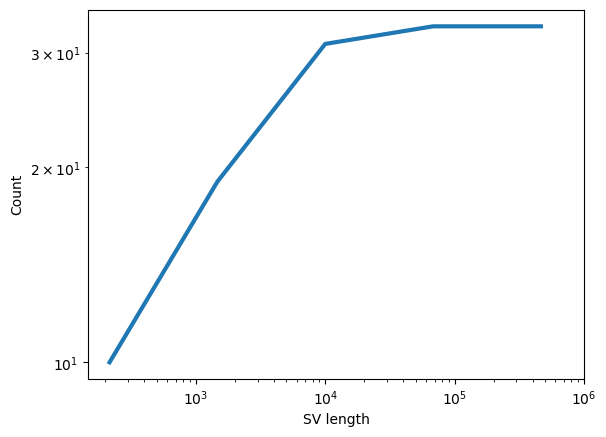

IL_ins: 0
IL_del: 33
IL_dup: 17
IL_inv: 0
IL_bnd: 0
LR_ins: 7
LR_del: 11
LR_dup: 8
LR_inv: 6
LR_bnd: 0
LR_IL_ins: 1
LR_IL_del: 26
LR_IL_dup: 27
LR_IL_inv: 1
LR_IL_bnd: 0
plots_svs/IL_vs_LR_venn_allSVs_coding_constraint_SQ20_SAMPLES_freq1.png


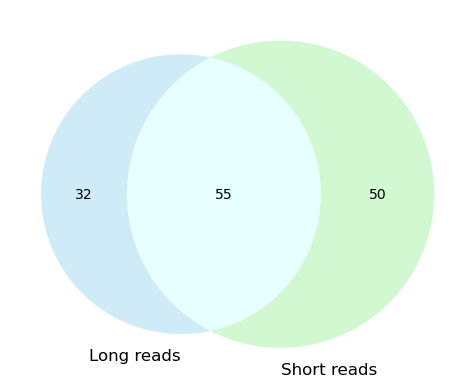

plots_svs/IL_vs_LR_venn_ins_coding_constraint_SQ20_SAMPLES_freq1.png


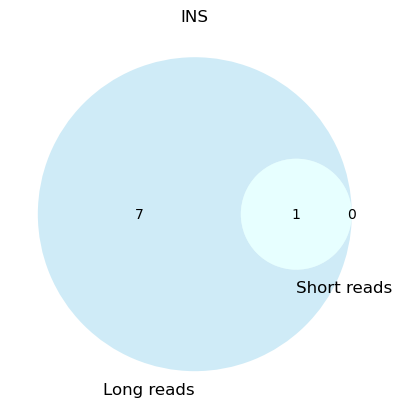

plots_svs/IL_vs_LR_venn_del_coding_constraint_SQ20_SAMPLES_freq1.png


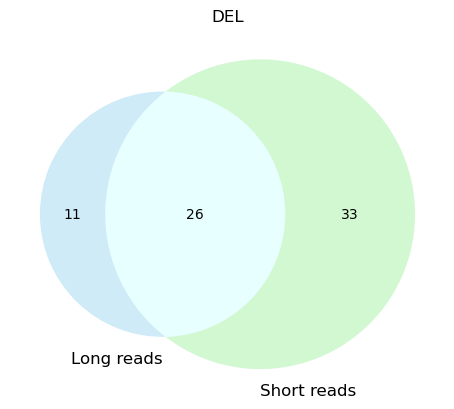

plots_svs/IL_vs_LR_venn_dup_coding_constraint_SQ20_SAMPLES_freq1.png


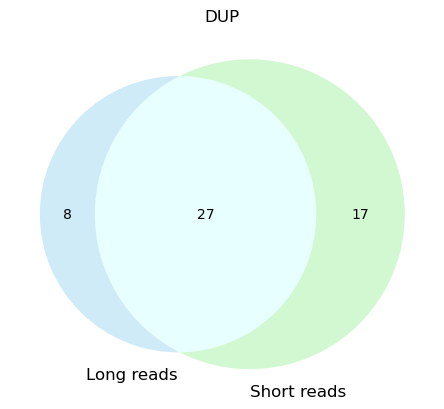

plots_svs/IL_vs_LR_venn_inv_coding_constraint_SQ20_SAMPLES_freq1.png


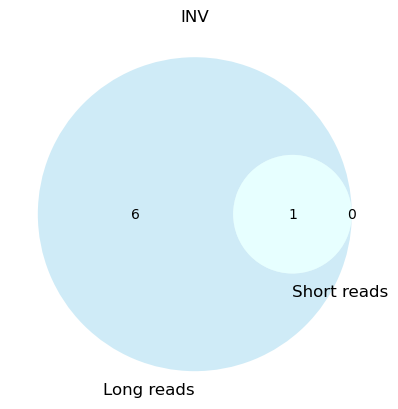

In [14]:
#flt_name = 'AD3_SAMPLES'
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=1
#freq_thr=0.05
freq_col = 'AD2_SAMPLES'

#title_add = f', {flt_name}, freq≤{freq_thr}'
title_add = f''

############# Coding constrained variants ##############
gen_list = ['CDS', 'start_codon', 'stop_codon']
# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
df_flt['constrained'] = df_flt.apply(lambda row: 1 if ((row.X_PLIp9==1) or (row.X_LOEUF==1) or 
                                                       (row.X_FDR_ASD==1) or (row.X_FDR_DD==1) or (row.X_FDR_NDD==1)) else 0, axis=1)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')
#display(df_flt)
#df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].to_csv(dir_fig+'test_data.tsv', sep='\t', 
#                                                                                                       header=True, index=False)

df_flt_len = df_flt.loc[(df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1) & (df_flt.SVTYPE!='.')].copy()
df_flt_len['SVLEN'] = df_flt_len['SVLEN'].astype(int).abs()
print(f'df_flt_len: {df_flt_len.shape}')
#fig_name = dir_fig+f'hist_svlen_coding_constrained_svs_{flt_name}_freq{freq_thr}.png'
fig_name = dir_fig+f'hist_svlen_allSVs_coding_constrained_{flt_name}_freq{freq_thr}_noPlat.png'
palette = {'LR': 'skyblue', 'IL':'lightgreen', 'LR_IL':'paleturquoise'}
bins = 5
#hist(df_flt_len, fig_name, palette=palette, title=title_add, bins=bins, hue='PLATFORM_CV')
hist(df_flt_len, fig_name, palette=palette, title=title_add, bins=bins)

IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='.') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_total = IL_ins + IL_del + IL_dup + IL_inv
print(f'IL_ins: {IL_ins}')
print(f'IL_del: {IL_del}')
print(f'IL_dup: {IL_dup}')
print(f'IL_inv: {IL_inv}')
print(f'IL_bnd: {IL_bnd}')

LR_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INS') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_total = LR_ins + LR_del + LR_dup + LR_inv
print(f'LR_ins: {LR_ins}')
print(f'LR_del: {LR_del}')
print(f'LR_dup: {LR_dup}')
print(f'LR_inv: {LR_inv}')
print(f'LR_bnd: {LR_bnd}')

LR_IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INS') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_total = LR_IL_ins + LR_IL_del + LR_IL_dup + LR_IL_inv
print(f'LR_IL_ins: {LR_IL_ins}')
print(f'LR_IL_del: {LR_IL_del}')
print(f'LR_IL_dup: {LR_IL_dup}')
print(f'LR_IL_inv: {LR_IL_inv}')
print(f'LR_IL_bnd: {LR_IL_bnd}')

venn_(LR_total, IL_total, LR_IL_total, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_allSVs_coding_constraint_{flt_name}_freq{freq_thr}.png', title=''+title_add)
venn_(LR_ins, IL_ins, LR_IL_ins, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_ins_coding_constraint_{flt_name}_freq{freq_thr}.png', title='INS'+title_add)
venn_(LR_del, IL_del, LR_IL_del, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_del_coding_constraint_{flt_name}_freq{freq_thr}.png', title='DEL'+title_add)
venn_(LR_dup, IL_dup, LR_IL_dup, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_dup_coding_constraint_{flt_name}_freq{freq_thr}.png', title='DUP'+title_add)
venn_(LR_inv, IL_inv, LR_IL_inv, ['Long reads', 'Short reads'], dir_fig+f'IL_vs_LR_venn_inv_coding_constraint_{flt_name}_freq{freq_thr}.png', title='INV'+title_add)


In [15]:
# psam data for all the REACH cohort
file_psam_all = '/expanse/projects/sebat1/genomicsdataanalysis/REACH_JG/docs/REACH.2022_01_07.psam'
df_p = pd.read_table(file_psam_all, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
display(df_p)

# make mom and dad dictionary
sample_dad_dict = {}
sample_mom_dict = {}
for sample, dad, mom in zip(df_p.sample_id, df_p.dad, df_p.mom):
    #print(sample, dad, mom)
    sample_dad_dict[sample] = dad
    sample_mom_dict[sample] = mom

,famid,sample_id,dad,mom,sex,phen
0,AUTPGX_4,1004,3004,2004,1,2
1,AUTPGX_5,1005,3005,2005,1,2
2,AUTPGX_8,1008,3008,2008,1,2
3,AUTPGX_14,1014,3014,2014,1,2
4,AUTPGX_18,1018,3018,2018,1,2
...,...,...,...,...,...,...
1127,V5T5W,V5T5W_04,0,0,1,0
1128,X3N7Y,X3N7Y_01,X3N7Y_04,X3N7Y_03,1,2
1129,X3N7Y,X3N7Y_03,0,0,2,0
1130,X3N7Y,X3N7Y_04,0,0,1,0


In [16]:
file_psam_lr = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/process_IL_LR/HWE/REACH_LR_platform.psam'
df_p_lr = pd.read_table(file_psam_lr, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
df_p_lr['sample_id'] = df_p_lr.apply(lambda row: row['sample_id'].rstrip('_PB').rstrip('_ONT').rstrip('_IL'), axis=1)
df_p_lr['dad'] = df_p_lr.apply(lambda row: row['dad'].rstrip('_PB').rstrip('_ONT').rstrip('_IL'), axis=1)
df_p_lr['mom'] = df_p_lr.apply(lambda row: row['mom'].rstrip('_PB').rstrip('_ONT').rstrip('_IL'), axis=1)
display(df_p_lr)

print('complete trios:')
df_trios = df_p_lr.loc[df_p_lr.dad.isin(df_p_lr.sample_id) & df_p_lr.mom.isin(df_p_lr.sample_id)]
display(df_trios)

,famid,sample_id,dad,mom,sex,phen
0,2323,2323-2-1,0,0,2,2
1,2602,2602-2-1,0,0,2,2
2,3392,3392-2-3,0,0,2,2
3,3538,3538-2-1,0,0,2,2
4,3939,3939-3-1,0,0,2,2
...,...,...,...,...,...,...
275,F0270,REACH000681,REACH000683,REACH000682,1,2
276,F0270,REACH000682,0,0,2,2
277,F0270,REACH000683,0,0,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


complete trios:


,famid,sample_id,dad,mom,sex,phen
10,F0026,REACH000026,REACH000270,REACH000269,1,2
11,F0058,REACH000058,REACH000440,REACH000439,1,2
12,F0065,REACH000065,REACH000067,REACH000066,1,2
15,F0078,REACH000086,REACH000088,REACH000087,1,2
18,F0078,REACH000089,REACH000088,REACH000087,2,2
...,...,...,...,...,...,...
271,F0266,REACH000660,REACH000662,REACH000661,2,2
274,F0266,REACH000663,REACH000662,REACH000661,1,1
275,F0270,REACH000681,REACH000683,REACH000682,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


In [17]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)
df_meta.set_index('Sample_ID', inplace=True)
display(df_meta)

,Subject_ID,Family_ID,DOB,Family_Type,Affected,Diagnosis_LAB,Mother_ID,Father_ID,Rel_Proband,Chrono_Age (months),...,Date sent for DNA extraction,Location of DNA extraction,DNA Box,Concentration (ng/uL),260/280,Date sent for Sequencing,WGS Provider,(Sample Well) Plate Name.Sample.ID,Affected_orig,Affected_ASD
Sample_ID,,,,,,,,,,,,,,,,,,,,,
REACH000001,F0001-01,F0001,3/26/2007,trio,Yes,Autism,F0001-02,F0001-03,Proband,46,...,Unknown,Gleeson,1,60.0,1.80,9/9/2013,Illumina,LP6005688-DNA_E11,Yes,Yes
REACH000107,F0001-02,F0001,8/9/1972,trio,Yes,Autism,Unknown,Unknown,Mom,475,...,Unknown,Gleeson,2,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_F11,Yes,Yes
REACH000226,F0001-03,F0001,9/27/1969,trio,Yes,"Autism, PTSD, ADHD",Unknown,Unknown,Dad,523,...,Unknown,Gleeson,3,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_G11,Yes,Yes
REACH000002,F0002-01,F0002,11/19/2007,incomplete,Yes,Autism,Unknown,Unknown,Proband,38,...,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family,Yes,Yes
REACH000003,F0003-01,F0003,8/9/2000,incomplete,Yes,Autism,Unknown,Unknown,Proband,126,...,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REACH000889,F0320-02,F0320,1/15/1981,multiple,No,"Crohn's Disease, Lupus (SLE)",F8888-88,F8888-88,Mom,431,...,2/28/2017,Sebat,11,36.2,1.79,pending,pending,pending,No,No
REACH000890,F0320-03,F0320,7/9/1980,multiple,No,NaN,F8888-88,F8888-88,Dad,437,...,2/28/2017,Sebat,11,41.9,1.84,pending,pending,pending,No,No
REACH000891,F0320-04,F0320,2/26/2010,multiple,No,NaN,F0320-02,F0320-03,Sibling,81,...,2/28/2017,Sebat,11,119.7,1.84,pending,pending,pending,No,No


In [18]:
# pca file for REACH + SSC + SPARK
file_pca = '/expanse/projects/sebat1/j3guevar/SFARI/aspera-sf/SFARI_DS468588/data/master_phen_4.SBayesR.20210915.csv'
df_pca = pd.read_table(file_pca, sep=',', header=0)
cols = ['fid', 'iid', 'phen','sex','cohort','duo','family','is_eur','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 
        'PC1_PAT','PC2_PAT','PC3_PAT','PC4_PAT','PC5_PAT','PC6_PAT','PC7_PAT','PC8_PAT','PC9_PAT','PC10_PAT', 
        'PC1_MAT','PC2_MAT','PC3_MAT','PC4_MAT','PC5_MAT','PC6_MAT','PC7_MAT','PC8_MAT','PC9_MAT','PC10_MAT']
df_pca = df_pca[cols]
print(f'df_pca size: {df_pca.shape[0]}')

# only look at REACH samples
df_pca_flt = df_pca.loc[df_pca.iid.str.contains('REACH')].copy()
df_pca_flt['rel'] = 'C'
print(f'REACH, df_pca_flt size: {df_pca_flt.shape[0]}')
#display(df_pca_flt)

df_parents = pd.DataFrame()
for index, row in df_pca_flt.iterrows():
    sample = row['iid']
    fid = row['fid']
    phen = row['phen']
    is_eur = row['is_eur']
    pc_mat = [row[f'PC{x}_MAT'] for x in range(1,11)]
    pc_pat = [row[f'PC{x}_PAT'] for x in range(1,11)]
    dad = sample_dad_dict[sample]
    mom = sample_mom_dict[sample]
    
    dict_mat = {'fid': [fid], 'iid': [mom], 'phen': ['.'], 'sex': ['Female'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_mat.update({f'PC{x}': [pc_mat[x-1]] for x in range(1,11)})
    df_mat = pd.DataFrame(dict_mat)

    dict_pat = {'fid': [fid], 'iid': [dad], 'phen': ['.'], 'sex': ['Male'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_pat.update({f'PC{x}': [pc_pat[x-1]] for x in range(1,11)})
    df_pat = pd.DataFrame(dict_pat)
    
    if df_parents.shape[0] == 0 or mom not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_mat])
    if df_parents.shape[0] == 0 or dad not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_pat])

df_parents['rel'] = 'P'
print(f'REACH, df_parents size: {df_parents.shape[0]}')
#print('df_parents:')
#display(df_parents)

# merge children and parents
df_pca_flt = pd.concat([df_pca_flt, df_parents])
print(f'REACH, children + parents size: {df_pca_flt.shape[0]}')

# Add Race column
df_pca_flt['Race'] = df_pca_flt['iid'].map(df_meta['Race'])
display(df_pca_flt)

df_pca_flt_lr = df_pca_flt.loc[df_pca_flt.iid.isin(df_trios.sample_id.tolist()+df_trios.mom.tolist()+df_trios.dad.tolist())]
print(f'REACH LR, children + parents size: {df_pca_flt_lr.shape[0]}')

df_pca size: 17460
REACH, df_pca_flt size: 281
REACH, df_parents size: 309
REACH, children + parents size: 590


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,rel,Race
136,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,C,White
137,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,C,Other
138,F0050,REACH000050,ASD,Male,1,trio,1.0,1,-0.007029,0.022216,...,0.004346,-0.024711,-0.008170,-0.018570,0.001443,0.002810,-0.000927,-0.001673,C,White
139,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,C,White
140,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906,C,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0291,REACH000769,.,Male,1,.,NaN,0,0.086006,-0.003008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,Other
0,F0162C,REACH000775,.,Female,1,.,NaN,1,-0.006961,0.001684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,White
0,F0162C,REACH000776,.,Male,1,.,NaN,1,-0.011109,0.010559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,White
0,F0162B,REACH000772,.,Female,1,.,NaN,1,-0.015162,0.008165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,White


REACH LR, children + parents size: 243


plots_svs/REACH_SSC_SPARK_PC1_vs_PC2.png


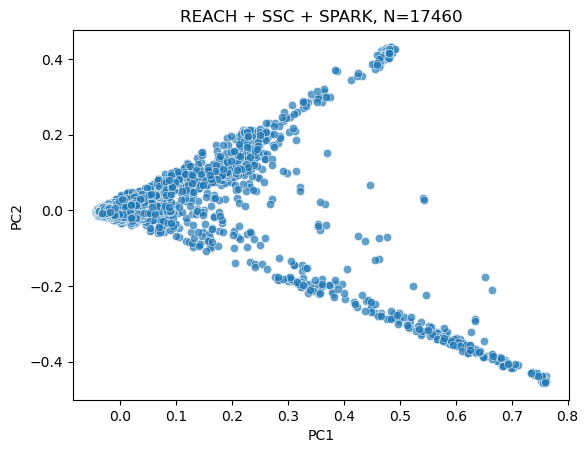

plots_svs/REACH_ALL_PC1_vs_PC2.png


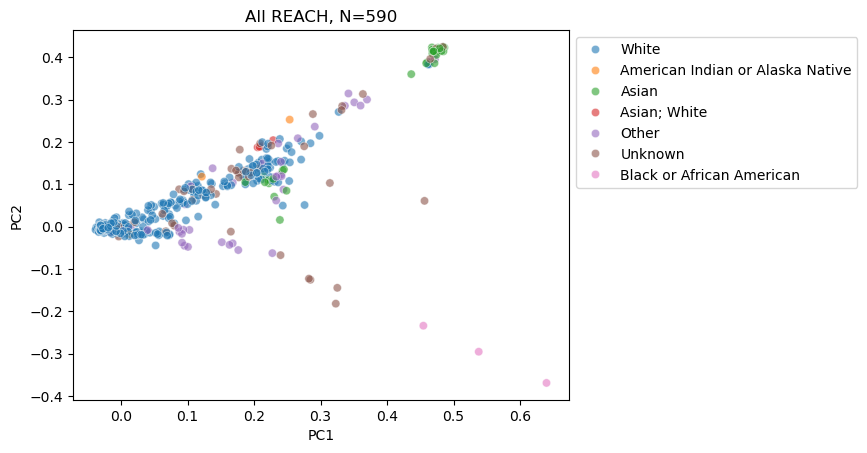

plots_svs/REACH_LR_PC1_vs_PC2.png


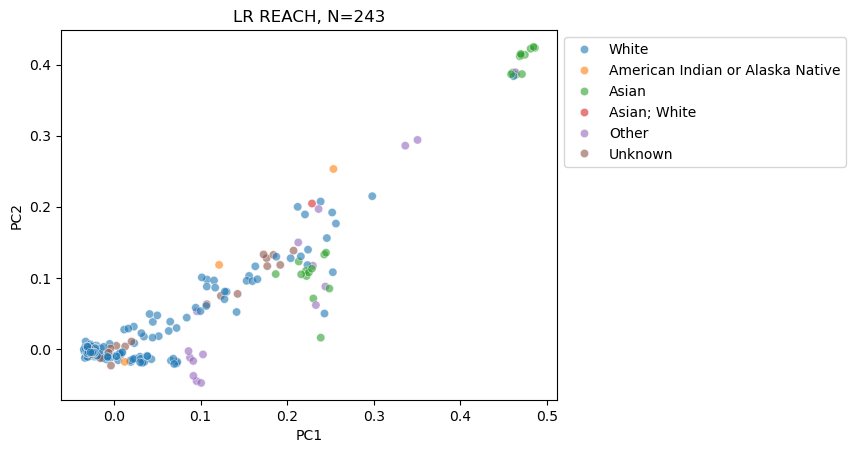

In [19]:
import seaborn as sb

hue_order = ['White', 'American Indian or Alaska Native', 'Asian', 'Asian; White', 'Other', 'Unknown', 'Black or African American']

plt.figure()
sb.scatterplot(data=df_pca, x='PC1', y='PC2', alpha = .7)
plt.title(f'REACH + SSC + SPARK, N={df_pca.shape[0]}')
#plt.legend(bbox_to_anchor=(1,1), loc='upper left')
fig_name = dir_fig + 'REACH_SSC_SPARK_PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
sb.scatterplot(data=df_pca_flt, x='PC1', y='PC2', hue='Race', hue_order=hue_order, alpha = .6)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title(f'All REACH, N={df_pca_flt.shape[0]}')
fig_name = dir_fig + 'REACH_ALL_PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
sb.scatterplot(data=df_pca_flt_lr, x='PC1', y='PC2', hue='Race', hue_order=hue_order[:-1], alpha = .6)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title(f'LR REACH, N={df_pca_flt_lr.shape[0]}')
fig_name = dir_fig + 'REACH_LR_PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

total: (344735, 434)
filtered: (207, 434)


PLATFORM_CV
LR_IL    96
IL       60
LR       51
Name: count, dtype: int64

labels: ['LR/IL', 'IL only', 'LR only']
counts: [96, 60, 51]
colors: ['lightcyan', 'lightgreen', 'skyblue']
plots_svs/platform_counts_exonicPLI_PLATFORM_CV_SQ20_SAMPLES_freq0.05.png


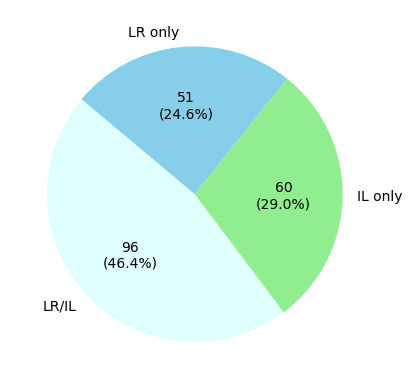

In [21]:
#flt_name = 'SQ70_SAMPLES'
flt_name = 'SQ20_SAMPLES'
#flt_name = 'SQ30_SAMPLES'
#flt_name = 'SQ40_SAMPLES'
#flt_name = 'SQ50_SAMPLES'
#flt_name = 'SQ60_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=0.05
freq_col = 'AD2_SAMPLES'

############# Exonic pLI≥.9 variants ##############
# filter for main svtypes and quality and frequency
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)

# filter for exonic variants
df_flt = df_flt.loc[(df_flt.X_PLIp9_cds==1) | (df_flt.X_PLIp9_utr==1)]

print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

#col_plat = 'PLATFORM'
col_plat = 'PLATFORM_CV'
#plat_counts = df_flt.PLATFORM.value_counts()
plat_counts = df_flt[col_plat].value_counts()
display(plat_counts)

label_dict = {'LR': 'LR only', 'IL': 'IL only', 'LR_IL': 'LR/IL'}
color_dict = {'LR': 'skyblue', 'IL': 'lightgreen', 'LR_IL': 'lightcyan'}
labels = [label_dict[x] for x in plat_counts.index.tolist()]
counts = plat_counts.values.tolist()  # Sizes of each slice
colors = [color_dict[x] for x in plat_counts.index.tolist()]
print(f'labels: {labels}')
print(f'counts: {counts}')
print(f'colors: {colors}')

def get_str(pct, cts):
    absolute = int(np.round(pct/100*np.sum(cts)))
    return f'{absolute}\n({pct:.1f}%)'
    
# Plotting the pie chart
plt.figure()
#plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.pie(counts, labels=labels, colors=colors, autopct=lambda pct: get_str(pct, counts), startangle=140)

# Display the pie chart
#fig_name = dir_fig + f'platform_counts_{flt_name}_freq{freq_thr}_exonicPLI.png'
fig_name = dir_fig + f'platform_counts_exonicPLI_{col_plat}_{flt_name}_freq{freq_thr}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [3]:
#prs_mode = 'sbayesr'
prs_mode = 'prscs'
if (prs_mode == 'sbayesr'):
    file_main = 'combined_svs_trs_snvs_prs_pc_sbayesr.csv'
elif (prs_mode == 'prscs'):
    file_main = 'combined_svs_trs_snvs_prs_pc_prscs.csv'
df_main = pd.read_table(file_main, header=0, sep=',')
display(df_main)

,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP1,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP1_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP2,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q,PRS_ASD_Z,PRS_SCZ_Z,PRS_EDU_Z,count_dnlof_inhlof
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,142,126,16,14,0,0,-0.971701,-0.510485,0.821629,0
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,1,1,1,1,1,1,0.303645,0.817056,0.063124,1
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,5,5,1,1,1,1,0.595643,-0.305437,1.943035,2
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0,0,0,0,0,0,1.166192,0.943709,-2.788964,1
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,2,1,1,0,0,0,0.703902,-0.152554,0.064824,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,2,1,0,0,0,0,0.364053,0.637902,0.380121,0
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,2,1,1,1,0,0,-1.292022,-0.527641,1.207045,0
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,0,0,0,0,0,0,-1.886279,-1.404394,-1.045699,0
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,0,0,0,0,0,0,1.535537,0.503982,1.545563,0


In [4]:
sub_dir_fig = 'inv/'

['count_LOWPLI_cds', 'count_LOWPLI_utr']


,iid,Platform,iid_plat,new_var
211,REACH000603,ONT,REACH000603|ONT,16
87,REACH000602,ONT,REACH000602|ONT,16
46,REACH000419,ONT,REACH000419|ONT,16
77,REACH000555,ONT,REACH000555|ONT,15
8,REACH000097,PB,REACH000097|PB,14
...,...,...,...,...
154,REACH000286,PB,REACH000286|PB,1
218,REACH000646,PB,REACH000646|PB,1
196,REACH000531_ONT,ONT,REACH000531_ONT|ONT,1
112,REACH000762,PB,REACH000762|PB,0


plots_svs/inv/svs_counts_hist_LOWPLI_all


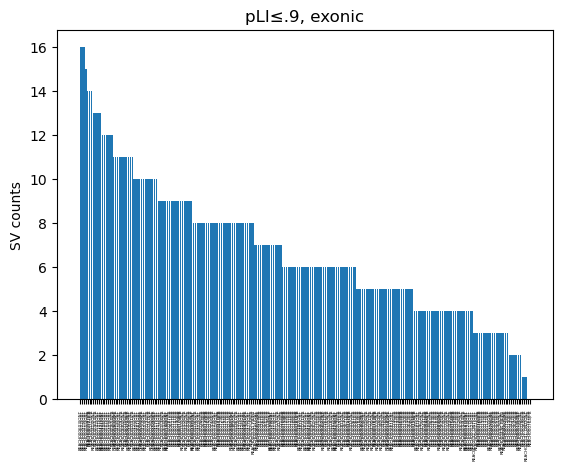

plots_svs/inv/svs_counts_hist_LOWPLI_ONT


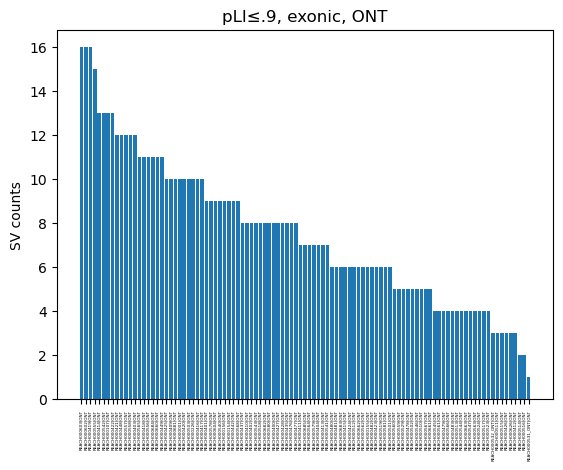

plots_svs/inv/svs_counts_hist_LOWPLI_PB


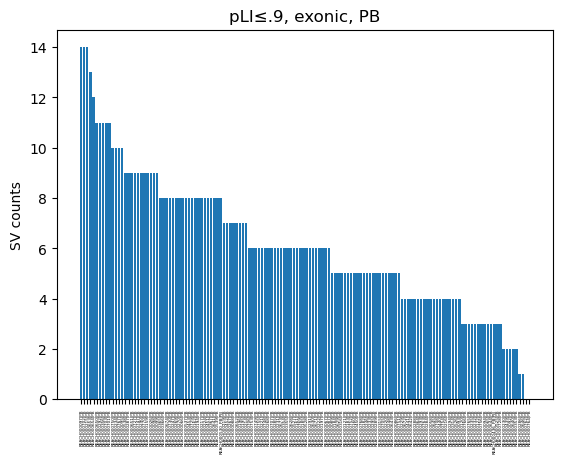

In [5]:
### SVs
ft = 'LOWPLI_cds + LOWPLI_utr'
ft_label = 'pLI≤.9, exonic'
fig_label = 'LOWPLI'
ft_tmp = ft.split('+')
ft_list = [f'count_{x.strip()}' for x in ft_tmp]
print(ft_list)

this_ser = df_main[ft_list[0]]
for col in ft_list[1:]:
    this_ser = this_ser + df_main[col]
#print(this_ser)

df_main['new_var'] = this_ser
df_sorted = df_main.sort_values(by='new_var', ascending=False)
df_sorted['iid_plat'] = df_sorted['iid'] + '|' + df_sorted['Platform']
display(df_sorted[['iid', 'Platform', 'iid_plat', 'new_var']])

fig, ax = plt.subplots()
ax.bar(df_sorted['iid_plat'], df_sorted['new_var'])
ax.set_xticks(df_sorted['iid_plat'], df_sorted['iid_plat'], rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(ft_label)
fig_name = dir_fig+sub_dir_fig+f'svs_counts_hist_{fig_label}_all'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
this_df = df_sorted.loc[df_sorted.Platform == 'ONT']
ax.bar(this_df['iid_plat'], this_df['new_var'])
ax.set_xticks(this_df['iid_plat'], this_df['iid_plat'], rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(f'{ft_label}, ONT')
fig_name = dir_fig+sub_dir_fig+f'svs_counts_hist_{fig_label}_ONT'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
this_df = df_sorted.loc[df_sorted.Platform == 'PB']
ax.bar(this_df['iid_plat'], this_df['new_var'])
ax.set_xticks(this_df['iid_plat'], this_df['iid_plat'], rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(f'{ft_label}, PB')
fig_name = dir_fig+sub_dir_fig+f'svs_counts_hist_{fig_label}_PB'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [6]:
### TRs
zs_thr = 3
supp_thr = 2
q_suf = '_Q'

ft = 'LOWPLI_cds + LOWPLI_utr'
ft_label = 'pLI≤.9, exonic'
fig_label = 'LOWPLI'
ft_tmp = ft.split('+')
ft_list = [f'count_ZS{zs_thr}_{x.strip()}_SUPP{supp_thr}{q_suf}' for x in ft_tmp]
print(ft_list)

this_ser = df_main[ft_list[0]]
for col in ft_list[1:]:
    this_ser = this_ser + df_main[col]
#print(this_ser)

df_main['new_var'] = this_ser
df_sorted = df_main.sort_values(by='new_var', ascending=False)
df_sorted['iid_plat'] = df_sorted['iid'] + '|' + df_sorted['Platform']
display(df_sorted[['iid', 'Platform', 'iid_plat', 'new_var']])

['count_ZS3_LOWPLI_cds_SUPP2_Q', 'count_ZS3_LOWPLI_utr_SUPP2_Q']


,iid,Platform,iid_plat,new_var
82,REACH000564,ONT,REACH000564|ONT,61
0,REACH000001,ONT,REACH000001|ONT,40
77,REACH000555,ONT,REACH000555|ONT,39
226,REACH000683,ONT,REACH000683|ONT,38
76,REACH000547,ONT,REACH000547|ONT,38
...,...,...,...,...
92,REACH000644,PB,REACH000644|PB,0
120,REACH000270,PB,REACH000270|PB,0
119,REACH000269,PB,REACH000269|PB,0
110,REACH000751,PB,REACH000751|PB,0


['count_ZS3_LOWPLI_cds_SUPP2_Q', 'count_ZS3_LOWPLI_utr_SUPP2_Q']


,iid,Platform,iid_plat,new_var
82,REACH000564,ONT,REACH000564|ONT,61
0,REACH000001,ONT,REACH000001|ONT,40
77,REACH000555,ONT,REACH000555|ONT,39
226,REACH000683,ONT,REACH000683|ONT,38
76,REACH000547,ONT,REACH000547|ONT,38
...,...,...,...,...
92,REACH000644,PB,REACH000644|PB,0
120,REACH000270,PB,REACH000270|PB,0
119,REACH000269,PB,REACH000269|PB,0
110,REACH000751,PB,REACH000751|PB,0


plots_svs/inv/trs_counts_hist_LOWPLI_all


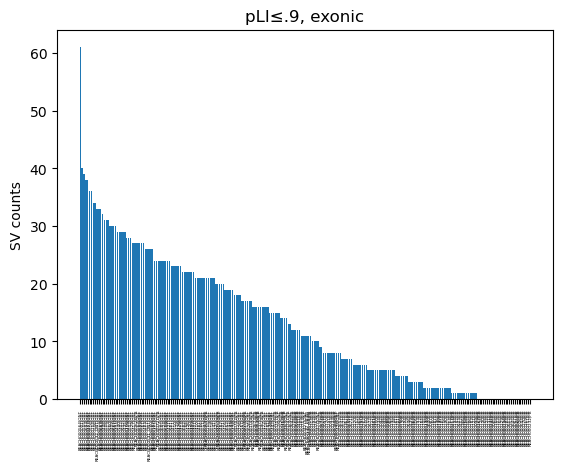

plots_svs/inv/trs_counts_hist_LOWPLI_ONT


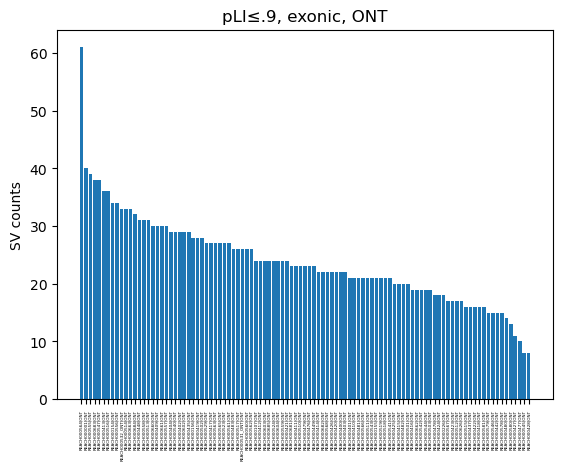

plots_svs/inv/trs_counts_hist_LOWPLI_PB


In [ ]:
### TRs
ft = 'LOWPLI_cds + LOWPLI_utr'
ft_label = 'pLI≤.9, exonic'
fig_label = 'LOWPLI'
ft_tmp = ft.split('+')
ft_list = [f'count_ZS{zs_thr}_{x.strip()}_SUPP{supp_thr}{q_suf}' for x in ft_tmp]
print(ft_list)

this_ser = df_main[ft_list[0]]
for col in ft_list[1:]:
    this_ser = this_ser + df_main[col]
#print(this_ser)

df_main['new_var'] = this_ser
df_sorted = df_main.sort_values(by='new_var', ascending=False)
df_sorted['iid_plat'] = df_sorted['iid'] + '|' + df_sorted['Platform']
display(df_sorted[['iid', 'Platform', 'iid_plat', 'new_var']])

fig, ax = plt.subplots()
ax.bar(df_sorted['iid_plat'], df_sorted['new_var'])
ax.set_xticks(df_sorted['iid_plat'], df_sorted['iid_plat'], rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(ft_label)
fig_name = dir_fig+sub_dir_fig+f'trs_counts_hist_{fig_label}_all'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
this_df = df_sorted.loc[df_sorted.Platform == 'ONT']
ax.bar(this_df['iid_plat'], this_df['new_var'])
ax.set_xticks(this_df['iid_plat'], this_df['iid_plat'], rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(f'{ft_label}, ONT')
fig_name = dir_fig+sub_dir_fig+f'trs_counts_hist_{fig_label}_ONT'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
this_df = df_sorted.loc[df_sorted.Platform == 'PB']
ax.bar(this_df['iid_plat'], this_df['new_var'])
ax.set_xticks(this_df['iid_plat'], this_df['iid_plat'], rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('SV counts')
plt.title(f'{ft_label}, PB')
fig_name = dir_fig+sub_dir_fig+f'trs_counts_hist_{fig_label}_PB'
print(fig_name)
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

total: (344735, 428)
filtered: (123, 428)


PLATFORM_CV_AD2
IL       60
LR_IL    52
LR       11
Name: count, dtype: int64

labels: ['IL only', 'LR/IL', 'LR only']
counts: [60, 52, 11]
colors: ['lightgreen', 'lightcyan', 'skyblue']
plots_svs/platform_counts_SQ70_SAMPLES_freq0.05_exonicPLI.png


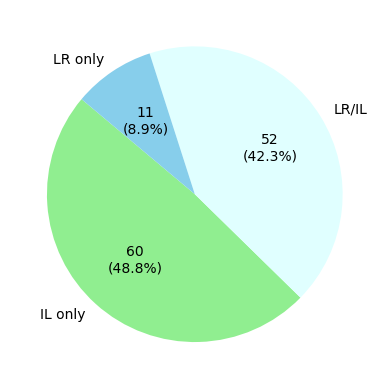

In [8]:
#flt_name = 'SQ70_SAMPLES'
flt_name = 'SQ20_SAMPLES'
#flt_name = 'SQ30_SAMPLES'
#flt_name = 'SQ40_SAMPLES'
#flt_name = 'SQ50_SAMPLES'
#flt_name = 'SQ60_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=0.05
freq_col = 'AD2_SAMPLES'

############# Exonic pLI≥.9 variants ##############
# filter for main svtypes and quality and frequency
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)

# filter for exonic variants
df_flt = df_flt.loc[(df_flt.X_PLIp9_cds==1) | (df_flt.X_PLIp9_utr==1)]

print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

#plat_counts = df_flt.PLATFORM.value_counts()
plat_counts = df_flt.PLATFORM_CV_AD2.value_counts()
display(plat_counts)

label_dict = {'LR': 'LR only', 'IL': 'IL only', 'LR_IL': 'LR/IL'}
color_dict = {'LR': 'skyblue', 'IL': 'lightgreen', 'LR_IL': 'lightcyan'}
labels = [label_dict[x] for x in plat_counts.index.tolist()]
counts = plat_counts.values.tolist()  # Sizes of each slice
colors = [color_dict[x] for x in plat_counts.index.tolist()]
print(f'labels: {labels}')
print(f'counts: {counts}')
print(f'colors: {colors}')

def get_str(pct, cts):
    absolute = int(np.round(pct/100*np.sum(cts)))
    return f'{absolute}\n({pct:.1f}%)'
    
# Plotting the pie chart
plt.figure()
#plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.pie(counts, labels=labels, colors=colors, autopct=lambda pct: get_str(pct, counts), startangle=140)

# Display the pie chart
#fig_name = dir_fig + f'platform_counts_{flt_name}_freq{freq_thr}_exonicPLI.png'
fig_name = dir_fig + 'tests/' + f'platform_counts_{flt_name}_freq{freq_thr}_exonicPLI.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plots_svs/SV_length_SQ70_SAMPLES.png


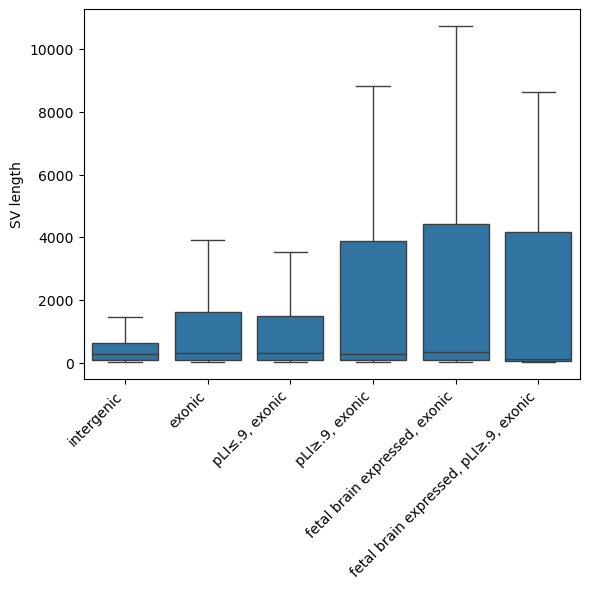

In [21]:
# plot length of SVs in different categories
flt_name = 'SQ70_SAMPLES'
dir_in = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/variant_prior/SV_process/data_tables/clean_tables/SQ70/'
file_names = ['table_intergenic_SQ70_SAMPLES.tsv', 
              'table_genic_cds_SQ70_SAMPLES.tsv', 'table_genic_utr_SQ70_SAMPLES.tsv', 'table_genic_intron_SQ70_SAMPLES.tsv',
              'table_LOWPLI_cds_SQ70_SAMPLES.tsv', 'table_LOWPLI_utr_SQ70_SAMPLES.tsv', 'table_LOWPLI_intron_SQ70_SAMPLES.tsv',
              'table_PLIp9_cds_SQ70_SAMPLES.tsv', 'table_PLIp9_utr_SQ70_SAMPLES.tsv', 'table_PLIp9_intron_SQ70_SAMPLES.tsv',
              'table_DEV_BR_GENE_10_cds_SQ70_SAMPLES.tsv', 'table_DEV_BR_GENE_10_utr_SQ70_SAMPLES.tsv', 'table_DEV_BR_GENE_10_intron_SQ70_SAMPLES.tsv',
              'table_PLIp9_DEV_BR_GENE_10_cds_SQ70_SAMPLES.tsv', 'table_PLIp9_DEV_BR_GENE_10_utr_SQ70_SAMPLES.tsv', 'table_PLIp9_DEV_BR_GENE_10_intron_SQ70_SAMPLES.tsv']
label_dict = {'intergenic': 'intergenic', 'genic_cds': 'exonic', 'genic_utr': 'exonic', 
              'LOWPLI_cds':'pLI≤.9, exonic', 'LOWPLI_utr': 'pLI≤.9, exonic', 'PLIp9_cds': 'pLI≥.9, exonic', 'PLIp9_utr': 'pLI≥.9, exonic', 
              'DEV_BR_GENE_10_cds': 'fetal brain expressed, exonic', 'DEV_BR_GENE_10_utr': 'fetal brain expressed, exonic', 
              'PLIp9_DEV_BR_GENE_10_cds': 'fetal brain expressed, pLI≥.9, exonic', 
              'PLIp9_DEV_BR_GENE_10_utr': 'fetal brain expressed, pLI≥.9, exonic'}
order = ['intergenic', 'exonic', 'pLI≤.9, exonic', 'pLI≥.9, exonic', 'fetal brain expressed, exonic', 'fetal brain expressed, pLI≥.9, exonic']

df_svlen = pd.DataFrame()
for file_name in file_names:
    label = file_name.lstrip('table_').rstrip('_SQ70_SAMPLES.tsv')
    if label not in label_dict:
        continue
    this_df = pd.read_table(dir_in+file_name, sep='\t', header = 0)
    this_df['label'] = label_dict[label]
    df_svlen = pd.concat([df_svlen, this_df], axis=0)
#display(df_svlen)
df_svlen = df_svlen.loc[df_svlen.SVLEN!='.']
df_svlen['SVLEN'] = df_svlen['SVLEN'].astype('int').abs()
#display(df_svlen)

plt.figure()
sb.boxplot(data=df_svlen, x='label', y='SVLEN', order=order, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('SV length')
fig_name = dir_fig+f'SV_length_{flt_name}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

total: (344735, 487)
filtered: (26505, 487)
frac_LR_in_IL:
median: 1.0
mean: 0.8082032742010373
frac_IL_in_LR:
median: 0.6666666666666666
mean: 0.6823908444863301
SVTYPE
DEL    3976
INS     776
DUP     375
INV       5
Name: count, dtype: int64
DEL: 3976 ,INS: 776 ,DUP: 375 ,INV: 5 
plots_svs/concordence_ILonly_with_LR_AD2_SAMPLES_fracLR.png


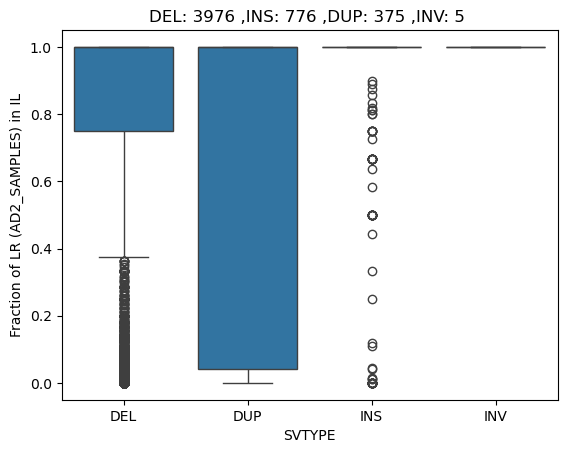

plots_svs/concordence_ILonly_with_LR_AD2_SAMPLES_fracIL.png


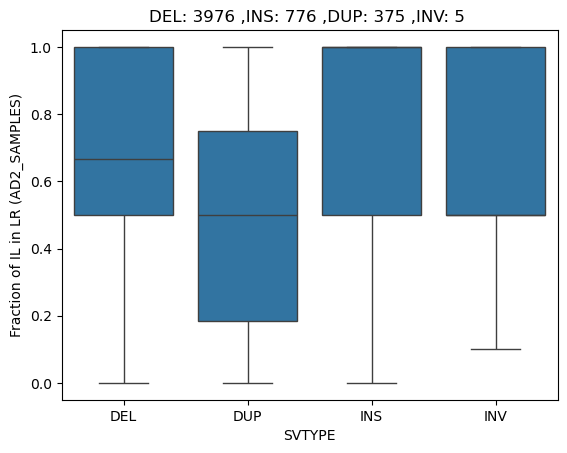

In [50]:
### overlap of IL-only calls with snoopsv genotypes
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
#freq_thr=1
freq_thr=0.05
freq_col = 'AD2_SAMPLES'
gen_list = ['CDS', 'start_codon', 'stop_codon']

############# All variants ##############
# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

############# quantify concordance #############
col_lr = 'AD2_SAMPLES'

def frac_LR_in_IL(row, col_lr):
    lr_list = [x for x in row[col_lr].split(',') if x != '.']
    il_list = [x for x in row['HET_SAMPLES'].split(',') if x != '.'] + [x for x in row['HOMALT_SAMPLES'].split(',') if x != '.']
    lr_in_il = [x for x in lr_list if x in il_list]
    il_in_lr = [x for x in il_list if x in lr_list]
    f_lr_in_il = 0
    f_il_in_lr = 0
    if len(lr_list) != 0:
        f_lr_in_il = len(lr_in_il) / len(lr_list)
    if len(il_list) != 0:
        f_il_in_lr = len(il_in_lr) / len(il_list)
    return f_lr_in_il, f_il_in_lr

df_flt_il = df_flt.loc[df_flt.PLATFORM=="IL"].copy()
df_flt_il.shape
df_flt_il[['frac_LR_in_IL', 'frac_IL_in_LR']] = df_flt_il.apply(lambda row: frac_LR_in_IL(row, col_lr), axis=1, result_type='expand')
#df_flt_il[['PLATFORM', 'frac_LR_in_IL', 'frac_IL_in_LR', 'HET_SAMPLES', 'HOMALT_SAMPLES', 'AD2_SAMPLES', 'SQ20_SAMPLES']]

############# plot concordance #############
### subset to calls with some LR evidence
this_df = df_flt_il.loc[df_flt_il[col_lr]!='.'].copy()

# change . to INS
this_df['SVTYPE'] = this_df['SVTYPE'].apply(lambda x: 'INS' if x=='.' else x)
#this_df.shape

print('frac_LR_in_IL:')
print(f'median: {np.median(this_df.frac_LR_in_IL)}')
print(f'mean: {np.mean(this_df.frac_LR_in_IL)}')

print('frac_IL_in_LR:')
print(f'median: {np.median(this_df.frac_IL_in_LR)}')
print(f'mean: {np.mean(this_df.frac_IL_in_LR)}')

sv_counts = this_df.SVTYPE.value_counts()
print(sv_counts)
title = ','.join([f'{x}: {sv_counts[x]} ' for x in sv_counts.index.tolist()])
print(title)

plt.figure()
sb.boxplot(data=this_df, x = 'SVTYPE', y='frac_LR_in_IL')
#plt.xticks(rotation=45, ha='right')
#plt.xlabel('')
plt.title(title)
plt.ylabel(f'Fraction of LR ({col_lr}) in IL')
fig_name = dir_fig + f'concordence_ILonly_with_LR_{col_lr}_fracLR.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
sb.boxplot(data=this_df, x = 'SVTYPE', y='frac_IL_in_LR')
#plt.xticks(rotation=45, ha='right')
#plt.xlabel('')
plt.title(title)
plt.ylabel(f'Fraction of IL in LR ({col_lr})')
fig_name = dir_fig + f'concordence_ILonly_with_LR_{col_lr}_fracIL.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

/scratch/smmortazavi/job_35065964/ipykernel_199002/1345328017.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sb.kdeplot(data=this_df, hue = 'SVTYPE', x='frac_LR_in_IL', common_norm=False)


plots_svs/concordence_ILonly_with_LR_AD2_SAMPLES_fracLR_density.png


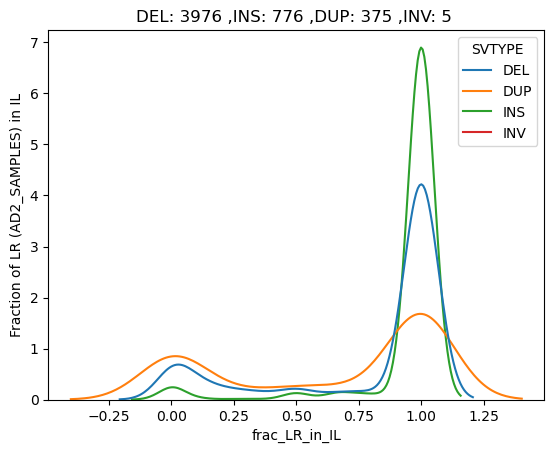

plots_svs/concordence_ILonly_with_LR_AD2_SAMPLES_fracIL_density.png


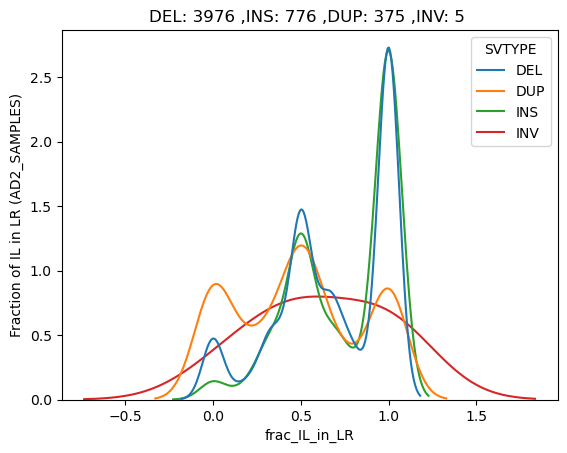

In [57]:
### plot distribution of data from the cell above
plt.figure()
sb.kdeplot(data=this_df, hue = 'SVTYPE', x='frac_LR_in_IL', common_norm=False)
#plt.xticks(rotation=45, ha='right')
#plt.xlabel('')
plt.title(title)
plt.ylabel(f'Fraction of LR ({col_lr}) in IL')
fig_name = dir_fig + f'concordence_ILonly_with_LR_{col_lr}_fracLR_density.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
sb.kdeplot(data=this_df, hue = 'SVTYPE', x='frac_IL_in_LR', common_norm=False)
#plt.xticks(rotation=45, ha='right')
#plt.xlabel('')
plt.title(title)
plt.ylabel(f'Fraction of IL in LR ({col_lr})')
fig_name = dir_fig + f'concordence_ILonly_with_LR_{col_lr}_fracIL_density.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

SV types included: ['DEL', 'DUP', 'INS']
total: (344735, 434)
filtered: (24792, 434)
filtered: SVTYPE
DEL    13538
INS     9577
DUP     1677
Name: count, dtype: int64
filtered: PLATFORM
LR       9385
IL       8422
LR_IL    6985
Name: count, dtype: int64
filtered LR: (9385, 434)
filtered LR: SVTYPE
INS    7203
DEL    1906
DUP     276
Name: count, dtype: int64
SVTYPE
DEL    151
INS     24
DUP     20
Name: count, dtype: int64
DEL: 151 ,INS: 24 ,DUP: 20 
plots_svs/concordence_LRonly_with_LR_AD2_SAMPLES_fracLR.png


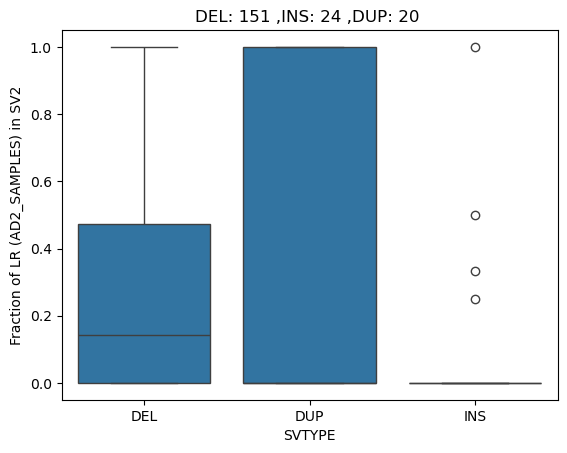

plots_svs/concordence_LRonly_with_LR_AD2_SAMPLES_fracSV2.png


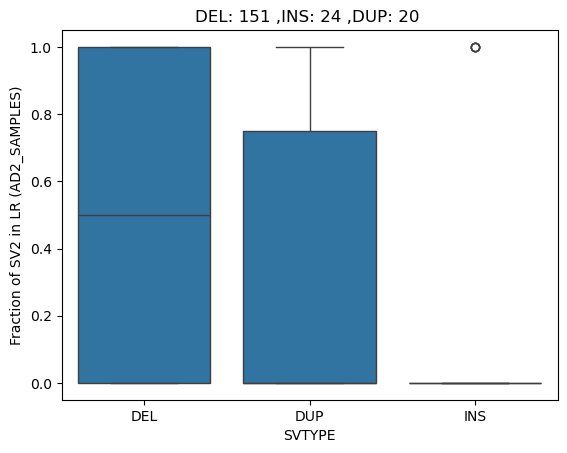

In [5]:
### overlap of LR-only calls with SV2 genotypes
flt_name = 'SQ20_SAMPLES'
#include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
include_svtypes = ['DEL', 'DUP', 'INS']
print(f'SV types included: {include_svtypes}')
#freq_thr=1
freq_thr=0.05
freq_col = 'AD2_SAMPLES'

############# All variants ##############
# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')
print(f'filtered: {df_flt.SVTYPE.value_counts()}')
print(f'filtered: {df_flt.PLATFORM.value_counts()}')

############# quantify concordance #############
col_lr = 'AD2_SAMPLES'
#col_lr = 'SQ20_SAMPLES'

def frac_LR_in_SV2(row, col_lr):
    #lr_list = [x for x in row[col_lr].split(',') if x != '.']
    #il_list = [x for x in row['HET_SAMPLES'].split(',') if x != '.'] + [x for x in row['HOMALT_SAMPLES'].split(',') if x != '.']
    lr_list = [x for x in row[col_lr].split(',') if 'REACH000' in x]
    sv2_list = [x for x in row['SV2_GT_SAMPLES'].split(',') if 'REACH000' in x]
    lr_in_sv2 = [x for x in lr_list if x in sv2_list]
    sv2_in_lr = [x for x in sv2_list if x in lr_list]
    f_lr_in_sv2 = 0
    f_sv2_in_lr = 0
    if len(lr_list) != 0:
        f_lr_in_sv2 = len(lr_in_sv2) / len(lr_list)
    if len(sv2_list) != 0:
        f_sv2_in_lr = len(sv2_in_lr) / len(sv2_list)
    return f_lr_in_sv2, f_sv2_in_lr

df_flt_lr = df_flt.loc[df_flt.PLATFORM=="LR"].copy()
print(f'filtered LR: {df_flt_lr.shape}')
print(f'filtered LR: {df_flt_lr.SVTYPE.value_counts()}')
df_flt_lr[['frac_LR_in_SV2', 'frac_SV2_in_LR']] = df_flt_lr.apply(lambda row: frac_LR_in_SV2(row, col_lr), axis=1, result_type='expand')
#df_flt_lr[['PLATFORM', 'frac_LR_in_IL', 'frac_IL_in_LR', 'HET_SAMPLES', 'HOMALT_SAMPLES', 'AD2_SAMPLES', 'SQ20_SAMPLES']]

############# plot concordance #############
### subset to calls with some LR evidence
#this_df = df_flt_lr.loc[df_flt_lr[col_lr]!='.'].copy()
this_df = df_flt_lr.loc[df_flt_lr['SV2_GT_SAMPLES']!='.'].copy()

# change . to INS
#this_df['SVTYPE'] = this_df['SVTYPE'].apply(lambda x: 'INS' if x=='.' else x)
#this_df.shape

#print('frac_LR_in_IL:')
#print(f'median: {np.median(this_df.frac_LR_in_IL)}')
#print(f'mean: {np.mean(this_df.frac_LR_in_IL)}')

#print('frac_IL_in_LR:')
#print(f'median: {np.median(this_df.frac_IL_in_LR)}')
#print(f'mean: {np.mean(this_df.frac_IL_in_LR)}')

sv_counts = this_df.SVTYPE.value_counts()
#sv_counts = df_flt_lr.SVTYPE.value_counts()
print(sv_counts)
title = ','.join([f'{x}: {sv_counts[x]} ' for x in sv_counts.index.tolist()])
print(title)

plt.figure()
#sb.boxplot(data=this_df, x = 'SVTYPE', y='frac_LR_in_IL')
#sb.boxplot(data=df_flt_lr, x = 'SVTYPE', y='frac_LR_in_SV2')
sb.boxplot(data=this_df, x = 'SVTYPE', y='frac_LR_in_SV2')
#plt.xticks(rotation=45, ha='right')
#plt.xlabel('')
plt.title(title)
plt.ylabel(f'Fraction of LR ({col_lr}) in SV2')
fig_name = dir_fig + f'concordence_LRonly_with_LR_{col_lr}_fracLR.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
#sb.boxplot(data=df_flt_lr, x = 'SVTYPE', y='frac_SV2_in_LR')
sb.boxplot(data=this_df, x = 'SVTYPE', y='frac_SV2_in_LR')
#plt.xticks(rotation=45, ha='right')
#plt.xlabel('')
plt.title(title)
plt.ylabel(f'Fraction of SV2 in LR ({col_lr})')
fig_name = dir_fig + f'concordence_LRonly_with_LR_{col_lr}_fracSV2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plots_svs/concordence_LRonly_with_LR_AD2_SAMPLES_fracLR_density.png


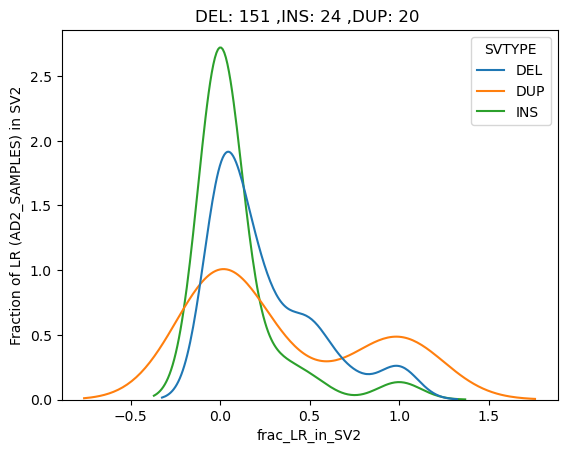

plots_svs/concordence_LRonly_with_LR_AD2_SAMPLES_fracSV2_density.png


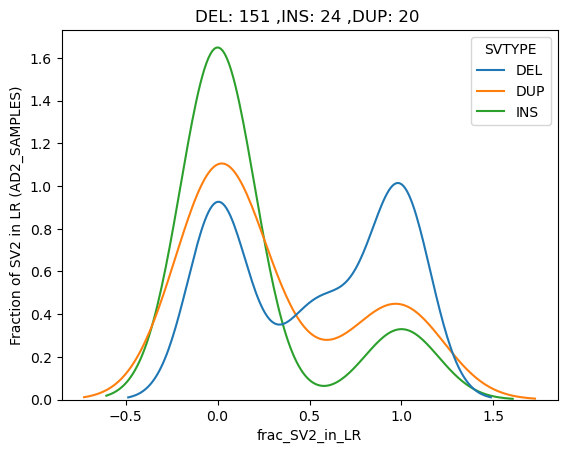

In [6]:
### plot distribution of data from the cell above
plt.figure()
sb.kdeplot(data=this_df, hue = 'SVTYPE', x='frac_LR_in_SV2', common_norm=False)
#plt.xticks(rotation=45, ha='right')
#plt.xlabel('')
plt.title(title)
plt.ylabel(f'Fraction of LR ({col_lr}) in SV2')
fig_name = dir_fig + f'concordence_LRonly_with_LR_{col_lr}_fracLR_density.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
sb.kdeplot(data=this_df, hue = 'SVTYPE', x='frac_SV2_in_LR', common_norm=False)
#plt.xticks(rotation=45, ha='right')
#plt.xlabel('')
plt.title(title)
plt.ylabel(f'Fraction of SV2 in LR ({col_lr})')
fig_name = dir_fig + f'concordence_LRonly_with_LR_{col_lr}_fracSV2_density.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()